Excelente Overview: https://doi.org/10.1109/JPHOTOV.2015.2395137

# Modelando um Painel Fotovoltaico a partir das curvas do datasheet
VER: https://pvpmc.sandia.gov/  
De Soto, 2006: https://minds.wisconsin.edu/bitstream/handle/1793/7602/desoto04.pdf?sequence=1
ou https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/de-soto-5-parameter-model/

A partir do [datasheet](https://www.jinkosolar.com/ftp/EN-JKM270P-60(4BB).pdf), os dados das curvas de tensão-corrente para as diversas radiações foram extraídas usando as ferramentas [GraphReader](http://www.graphreader.com) e [WebPlotDigitizer](https://apps.automeris.io/wpd/), tratadas (interpoladas para se obter dados de tensão uniformemente distribuídos) e salvas em um banco de dados de valores separados por vírgulas (.csv), de forma a ser facilmente legível por programas e também por humanos.

## Leitura do banco de dados
A leitura do banco de dados pode ser feita de maneira simples a partir da biblioteca Pandas.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'

df = pd.read_csv('dataset/JKM260P-60B.csv').fillna(0)
df


V [V]  I [A] (1000 W/m²)  I [A] (800 W/m²)  I [A] (600 W/m²)  \
0      0.1              8.906             7.167             5.259   
1      0.2              8.906             7.167             5.259   
2      0.3              8.906             7.167             5.259   
3      0.4              8.906             7.167             5.258   
4      0.5              8.906             7.167             5.258   
..     ...                ...               ...               ...   
375   37.6              0.765             0.000             0.000   
376   37.7              0.584             0.000             0.000   
377   37.8              0.404             0.000             0.000   
378   37.9              0.224             0.000             0.000   
379   38.0              0.043             0.000             0.000   

     I [A] (400 W/m²)  
0               3.450  
1               3.450  
2               3.450  
3               3.450  
4               3.449  
..                ...  
375             0.000  
376             0.000  
377             0.000  
378             0.000  
379             0.000  

[380 rows x 5 columns]

## Modelo de 5 parâmetros (L5P)

Conforme [A.Elkholy, 2019](https://www.sciencedirect.com/science/article/pii/S2405844019357974), um painel fotovoltaico pode ser modelado como um circuito, contendo cinco parâmetros ("LP5"), resultando nas seguintes equações:

$$
\begin{align*}
    i_{pv}(t) &= i_{ph}(t) -i_{D}(t) -i_{R_p}(t) \\
    i_{D}(t) &= i_{0} \left( \exp{\left(
        \frac{
            q \left( 
                v_{pv}(t) + R_{s}(t) i_{pv}(t)
                \right) 
         }{ 
             n N_{s} k T_{c}(t) 
         }
    \right)} -1 \right) \\
    i_{Rp}(t) &= \frac{ 
        v_{pv}(t) + R_{s}(t) i_{pv}(t) 
    }{ 
        N_{s} R_{p}(t)'
    } \\
\end{align*}
$$

Definindo as seguintes simplificações:

\begin{align*}
    R_{p}(t) &= N_{s} R_{p}(t)' \\
    v_{th}(t) &= \frac{ k T_{c}(t) }{ q } \\
    a(t) &= n N_{s} v_{th}(t) \\
\end{align*}

Resultando em:
$$
\boxed{
    i_{pv}(t) = i_{ph}(t) - i_{0}(t) \left( \exp\left( \frac{v_{pv}(t) +R_{s}(t)i_{pv}(t)}{a(t)} \right) -1 \right) - \frac{v_{pv}(t) + R_{s}(t)i_{pv}(t)}{R_{p}(t)}
}
$$



Sendo:

\begin{align*}
    T_{c}(t) & : \text{Temperatura da célula [K]} \\
    
    R_{s}(t) & : \text{Resistência em série [$\Omega$]} \\
    
    R_{p}(t) & : \text{Resistência em paralelo [$\Omega$]} \\
    
    i_{D}(t) & : \text{Corrente do diodo (equação do diodo de Shockley) [A]} \\

    i_{pv}(t) & : \text{Corrente do painel fotovoltaico [A]} \\

    v_{pv}(t) & : \text{Tensão do painel fotovoltaico [A]} \\

    i_{0}(t) & : \text{Corrente de saturação escura de Shockley [A]} \\

    N_{s} & : \text{Número de células em série [eV]} \\

    V_{th} & : \text{Tensão térmica do diodo [eV]} \\

    n & : \text{Fator de qualidade do diodo} \\

    a(t) & : \text{Coeficiente de não-idealidades [eV]} \\

    q & : \text{Carga elementar do elétron ($1.602176634 \times 10^{−19}$) [C]} \\

    k & : \text{Constante de Boltzmann ($8.617332478 \times 10^{-05}$) [eV/K]} \\
\end{align*}

Podemos calcular o valor de cada variável de acordo com um modelo construído para as Condições Teste Padrão (STC), compensando-as para a irradiação ($G$) e temperatura da célula ($T_{c}$):

\begin{align*}
    i_{ph}(t) &= \frac{G(t)}{G_{STC}} \left( i_{ph, STC} + \alpha_{sc} \left( T_{cell}(t) - T_{cell, STC} \right) \right) \\
    E_g(t) &= E_{g, STC} \left(1.0 + \frac{dE_g}{dT_{STC}} \left( T_{cell}(t) - T_{cell, STC} \right) \right) \\
    a(t) &= a_{STC} \frac{T_{cell}(t)}{T_{cell, STC}} \\
    i_{0}(t) &= i_{0, STC} \left( \frac{T_{cell}(t)}{T_{cell, STC}} \right)^3 \exp\left(\frac{E_{g, STC}}{kT_{cell, STC}} - \frac{E_g(t)}{kT_{cell}(t)}\right) \\
    R_{s}(t) &= R_{s, STC} \frac{T_{cell}(t)}{T_{cell, STC}} \left(1 - \beta_{oc} \ln\left(\frac{G(t)}{G_{STC}}\right)\right) \\
    R_{p}(t) &= R_{p, STC} \frac{G_{STC}}{G(t)}
\end{align*}



Sendo:

\begin{align*}
    T_{c}(t) \;,\, T_{c, STC} & : \text{Temperatura da célula em operação e em STC [K]} \\
    
    G(t) \;,\, G_{STC} & : \text{Irradiação solar em operação e em STC [W/m²]} \\

    E_g(t) \;,\, E_{g, STC}& : \text{Energia de bandgap em operação e em STC [eV]} \\

    \frac{dE_g}{dT_{STC}} & : \text{Taxa de variação da energia de bandgap em relação à temperatura em STC em operação e em STC [eV/K]} \\
    
    R_{s}(t) \;,\, R_{s, STC} & : \text{Resistência em série em operação e em STC [$\Omega$]} \\
    
    R_{p}(t) \;,\, R_{p, STC} & : \text{Resistência em paralelo em operação e em STC [$\Omega$]} \\
    
    i_{pv}(t) \;,\, i_{pv, STC} & : \text{Corrente fotovoltaica em operação e em STC [A]} \\

    i_{0}(t) \;,\, i_{0, STC} & : \text{Corrente de saturação escura de Shockley em operação e em STC [A]} \\

    a(t) \;,\, a_{STC} & : \text{Coeficiente de não-idealidades em operação e em STC [eV]} \\
    
    \alpha_{sc} & : \text{Coeficiente de temperatura da corrente de curto-circuito, descrita no datasheet [A/K]} \\
    \beta_{oc} & : \text{Coeficiente de temperatura da tensão de circuito aberto, descrita no datasheet [1/K]} \\

    k & : \text{Constante de Boltzmann ($8.617332478 \times 10^{-05}$) [eV/K]} \\
\end{align*}

Que pode ser resolvido utilizando a primeira raiz de Lambert W. ($W_{0}$), tanto para $i_{pv}$, quanto para $v_{pv}$, como indicado por [P.Lankireddy,2023](https://arxiv.org/pdf/2307.08099.pdf):
$$
\begin{align*}
    i_{pv}(t) &= \frac{{R_{p}(t)} \left( {i_{ph}(t)} + {i_{0}(t)} \right) - v_{pv}(t)}{{R_{p}(t)} + {R_{s}(t)}} - \frac{a(t)}{{R_{s}(t)}} {W_{0}} \left( \frac{{i_{0}(t)} {R_{p}(t)} {R_{s}(t)}    }{a(t) \left( {R_{p}(t)} + {R_{s}(t)} \right)} \, \exp{\left( \frac{{R_{p}(t)} \left( {R_{s}(t)} \left( {i_{ph}(t)} + {i_{0}(t)} \right) + v_{pv}(t) \right)}{a(t) \left( {R_{p}(t)} + {R_{s}(t)} \right)} \right)} \right)\\
    v_{pv}(t) &= {R_{p}(t)} \left( {i_{ph}(t)} + {i_{0}(t)} \right) - \left( {R_{p}(t)} + {R_{s}(t)} \right) i_{pv}(t) - a(t) {W_{0}} \left( \frac{{i_{0}(t)} {R_{p}(t)}}{a(t)} \exp{\left( \frac{{R_{p}(t)}}{a(t)} \left( {i_{ph}(t)} + {i_{0}(t)} - i_{pv}(t) \right) \right)} \right)
\end{align*}
$$

Caso a temperatura da célula não seja medida, modelos térmicos podem ser aplicados, como por exemplo, o [NOCT Model](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf) (Capítulo 23.3):

$$
\begin{align*}
    U_{L, NOCT} &= \frac{\left(\tau\,\alpha\right)}{T_{NOCT} - T_{a, NOCT}} \\
    Tc =& T_{a} +\frac{G(t)}{G_{NOCT}} \frac{U_{L,NOCT}}{U_{L}} \left( 1 - \frac{\eta_{c}}{\tau\,\alpha} \right) \left( T_{NOCT} - T_{a, NOCT} \right)
\end{align*}
$$

onde:

- $\tau\,\alpha$ é a Transmitância-Absortância Efetiva: resulta na energia que é absorvida, quando multiplicado pela radiação incidente, geralmente estimada como $0.9$.
- $\eta_{c}$ é a Eficiência do Módulo: representa a habilidade do módulo em converter a radiação incidente em energia elétrica.
- $U_{L}$ é o Coeficiente de Perda: inclui as perdas por convecção e radiação da parte superior e inferior, bem como por condução através de qualquer estrutura de montagem presente, todas em relação à temperatura ambiente ($T_{a}$).

In [30]:
# From datasheet:
Ns = 6*10  # Number of cells in serie
Pmax_STC = 260  # Maximum Power @ STC [W]
Pmax_NOCT = 193  # Maximum Power @ NOCT [W]
Vmp_STC = 31.1  # Maximum Power Voltage @ STC [V]
Vmp_NOCT = 28.7  # Maximum Power Voltage @ NOCT [V]
Imp_STC = 8.37  # Maximum Power Current @ STC [A]
Imp_NOCT = 6.71  # Maximum Power Current @ NOCT [A]
Voc_STC = 38.1  # Open Circuit Voltage @ STC [V]
Voc_NOCT = 35.2  # Open Circuit Voltage @ NOCT [V]
Isc_STC = 8.98  # Short-Circuit Current @ STC [A]
Isc_NOCT = 7.31  # Short-Circuit Current @ NOCT [A]
eta_STC = 0.1589  # Efficiency @ STC
Tc_STC = 25  # Cell Temperature @ STC [°C]
Ta_NOCT = 20  # Ambient Temperature @ NOCT [°C]
Tc_NOCT = 45  # Cell Temperature @ NOCT [°C]
G_STC = 1000  # Solar Irradiance @ STC [W/m^2]
G_NOCT = 800  # Solar Irradiance @ NOCT [W/m^2]
Asc = (0.06 / 100) * Isc_STC  # Temperature coefficient of Isc [A/°C]
Boc = (-0.31 / 100)  # Temperature coefficient of Voc [1/°C]
Gmp = (-0.41 / 100)  # Temperature coefficient of Pmp [1/°C]

# Constants (considering Crystalline Silicon (Si))
Eg_STC = 1.121  # Bandgap energy [eV]
dEgdT_STC = -0.0002677  # Temperature dependence of the energy bandgap at reference conditions [1/K]
k = 8.617332478e-05  # Boltzmann [eV/K]
# K = 1.380649e-23  # Boltzmann [J/K]
q = 1.602E-19  # Elementary charge [C]

# Define valores iniciais
Iph_0 = Isc_STC  # [A]
Tc_STC_K = Tc_STC + 273.15  # [K]
a_0 = 1.5 * k * Tc_STC_K * Ns  # [eV]
I0_0 = Isc_STC * np.exp(-Voc_STC / a_0)  # [A]
Rs_0 = (a_0 * np.log1p( (Iph_0 - Imp_STC) / I0_0) - Vmp_STC) / Imp_STC  # Ohms
Rp_0 = 100.0  # Ohms

# Define os limites da busca
b = 1e6
Iph_min = Iph_0 / b
Iph_max = Iph_0 * b
I0_min = I0_0 / b
I0_max = I0_0 * b
Rs_min = Rs_0 / b
Rs_max = Rs_0 * b
Rp_min = Rp_0 / b
Rp_max = Rp_0 * b
a_min = a_0 / b
a_max = a_0 * b


In [31]:
irradiation_data = np.array([1000, 800, 600, 400])
current_data = np.array([df[f'I [A] ({g} W/m²)'].to_numpy() for g in irradiation_data])
voltage_data = np.tile(df['V [V]'].to_numpy(), (len(irradiation_data),1))
temperature_data = np.ones(len(irradiation_data)) * Tc_STC

# I-V curve characteristics points
Isc_STC_data = np.array([current_data[k,i] for (k,i) in enumerate(voltage_data.argmin(axis=1))])
Voc_STC_data = np.array([voltage_data[k,i] for (k,i) in enumerate(current_data.argmin(axis=1))])
Imp_STC_data = np.array([current_data[k,i] for (k,i) in enumerate(np.argmax(current_data * voltage_data, axis=1))])
Vmp_STC_data = np.array([voltage_data[k,i] for (k,i) in enumerate(np.argmax(current_data * voltage_data, axis=1))])

print('G:', irradiation_data)
print('T:', temperature_data)
print('Isc:', Isc_STC_data)
print('Voc:', Voc_STC_data)
print('Imp:', Imp_STC_data)
print('Vmp:', Vmp_STC_data)

G: [1000  800  600  400]
T: [25. 25. 25. 25.]
Isc: [8.906 7.167 5.259 3.45 ]
Voc: [38.  37.6 37.2 36.3]
Imp: [8.264 6.583 4.846 3.227]
Vmp: [31.3 29.3 28.3 26.9]


## CEC-SAM model, from PVLib

Iph_STC: 8.993846289009927
I0_STC: 1.744576300895231e-10
Rs_STC: 0.2841295313003713
Rsh_STC: 184.27199696059222
a_ref_STC: 1.5461016821097358
Adjust: 11.028094857652386
G: 1000, rmse:  0.1281, mae:  0.07781
G:  800, rmse:  0.6159, mae:  0.3053
G:  600, rmse:  0.6443, mae:  0.3894
G:  400, rmse:  0.5259, mae:  0.3421


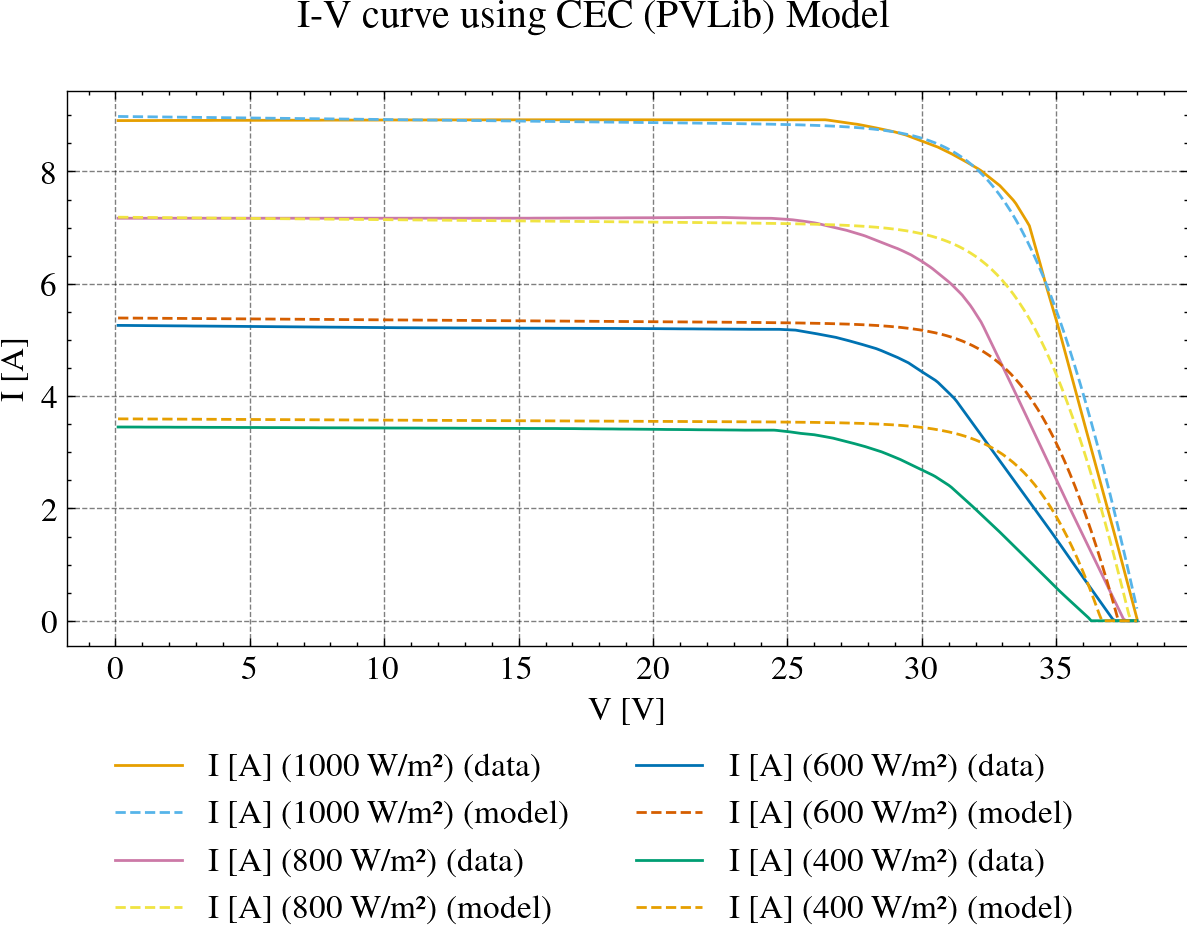

In [32]:
# Required: !pip install NREL-PySAM
import pvlib

Iph_STC, I0_STC, Rs_STC, Rsh_STC, a_ref_STC, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
    celltype='poly', v_mp=Vmp_STC, i_mp=Imp_STC, v_oc=Voc_STC, i_sc=Isc_STC, alpha_sc=Asc, beta_voc=Boc*Voc_STC, gamma_pmp=Gmp*100, cells_in_series=Ns, temp_ref=Tc_STC
)
print('Iph_STC:', Iph_STC)
print('I0_STC:', I0_STC)
print('Rs_STC:', Rs_STC)
print('Rsh_STC:', Rsh_STC)
print('a_ref_STC:', a_ref_STC)
print('Adjust:', Adjust)

plt.figure()

Tc = Tc_STC
for G in irradiation_data:
    Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_ref_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rsh_STC, R_s=Rs_STC, Adjust=Adjust, irrad_ref=G_STC, temp_ref=Tc_STC
    )

    i = pvlib.pvsystem.i_from_v(voltage=df['V [V]'], photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw')
    i = i.clip(min=0)

    col = f'I [A] ({G} W/m²)'
    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], i, '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - i
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

plt.xlabel('V [V]')
plt.ylabel('I [A]')

model_name = 'CEC (PVLib)'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_cec.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)


## PVSyst-Sandia (PVLib) model

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:688: RuntimeWarning: invalid value encountered in log
  logargW = (np.log(I0[idx_p]) - np.log(Gsh[idx_p]) -
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:688: RuntimeWarning: invalid value encountered in log
  logargW = (np.log(I0[idx_p]) - np.log(Gsh[idx_p]) -
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encoun

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:688: RuntimeWarning: invalid value encountered in log
  logargW = (np.log(I0[idx_p]) - np.log(Gsh[idx_p]) -
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encou

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2797e+00                                    1.29e+00    
       1              2         7.3804e-01      1.54e+00       1.66e+04       7.36e-01    
       2              3         1.4866e-01      5.89e-01       3.18e+03       3.30e-01    
       3              4         1.2107e-02      1.37e-01       7.54e+02       9.39e-02    
       4              5         1.5628e-04      1.20e-02       1.55e+02       1.03e-02    
       5              6         4.0706e-06      1.52e-04       1.34e+02       3.26e-01    
       6              7         1.3451e-11      4.07e-06       2.22e+02       1.59e-02    
       7              8         2.6014e-22      1.35e-11       3.78e-02       6.89e-08    
       8              9         0.0000e+00      2.60e-22       3.45e-07       0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 2.2797e+00

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


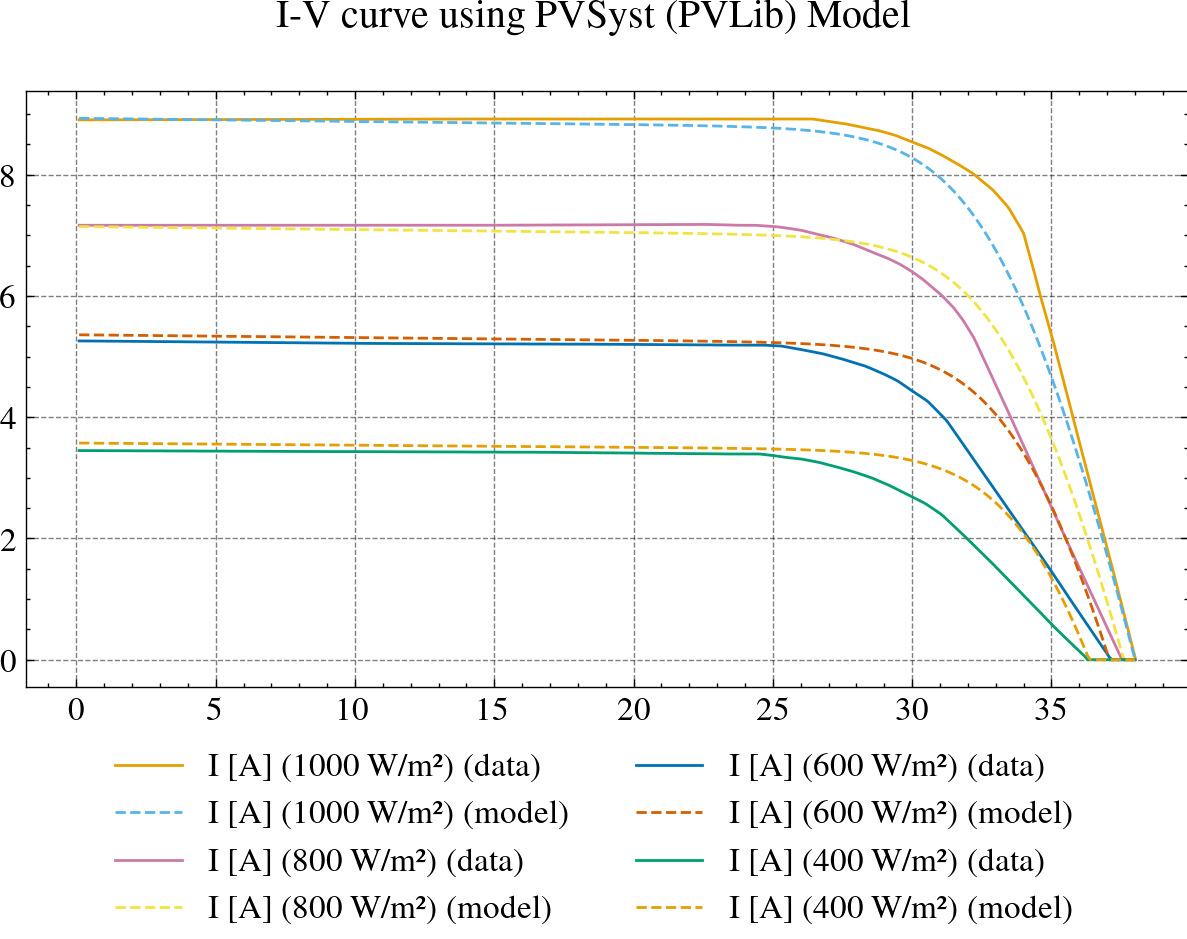

In [33]:
params = pvlib.ivtools.sdm.fit_pvsyst_sandia(
    ivcurves=dict(
        i=current_data,
        v=voltage_data,
        ee=irradiation_data,
        tc=temperature_data,
        i_sc=Isc_STC_data,
        v_oc=Voc_STC_data,
        i_mp=Imp_STC_data,
        v_mp=Vmp_STC_data,
    ),
    specs=dict(
        cells_in_series=Ns,
        alpha_sc=Asc,
    ),
    const=dict(
        E0=G_STC,
        T0=Tc_STC,
        k=1.380649e-23,  # Boltzmann [J/K],
        q=1.602E-19,  # Elementary charge [C],
    ),
    maxiter=100,
    eps1=0.001,
)
print('gamma_ref:', params['gamma_ref'])
print('mu_gamma:', params['mu_gamma'])
print('I_L_ref:', params['I_L_ref'])
print('I_o_ref:', params['I_o_ref'])
print('R_sh_ref:', params['R_sh_ref'])
print('R_sh_0:', params['R_sh_0'])
print('R_s:', params['R_s'])
print('R_sh_exp:', params['R_sh_exp'])

plt.figure()

Tc = Tc_STC
for G in irradiation_data:
    Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_pvsyst(
        effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, gamma_ref=params['gamma_ref'], mu_gamma=params['mu_gamma'], I_L_ref=params['I_L_ref'], I_o_ref=params['I_o_ref'], R_sh_ref=params['R_sh_ref'], R_sh_0=params['R_sh_0'], R_s=params['R_s'], cells_in_series=Ns, R_sh_exp=params['R_sh_exp'], EgRef=Eg_STC, irrad_ref=G_STC, temp_ref=Tc_STC
    )

    i = pvlib.pvsystem.i_from_v(voltage=df['V [V]'], photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw')
    i = i.clip(min=0)

    col = f'I [A] ({G} W/m²)'
    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], i, '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - i
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

model_name = 'PVSyst (PVLib)'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_pvsyst.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)


G: 1000, rmse:  0.4081, mae:  0.299
G:  800, rmse:  0.2628, mae:  0.1972
G:  600, rmse:  0.2591, mae:  0.1429
G:  400, rmse:  0.2004, mae:  0.1451


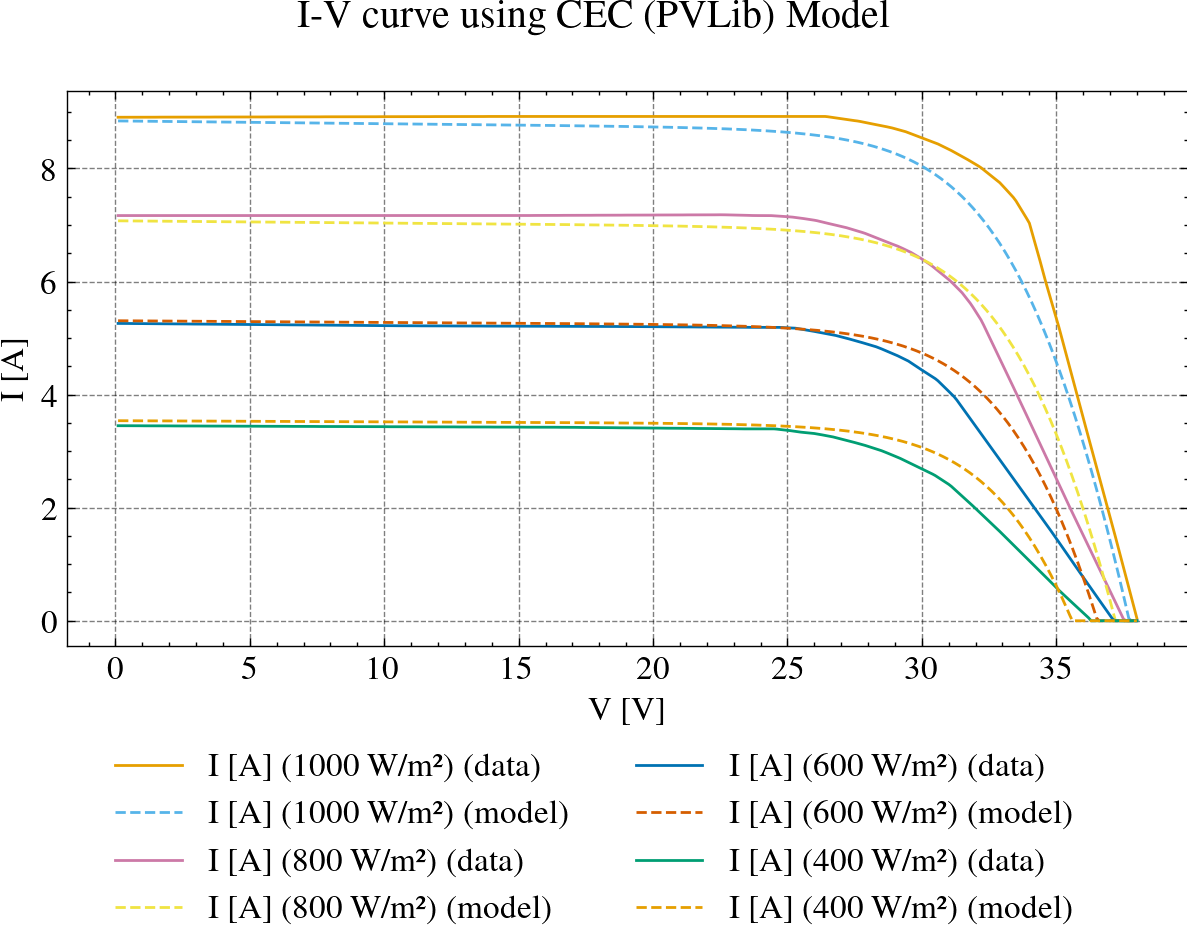

In [34]:
import pvlib
import lmfit

def func_CEC(V_data, G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, a_STC, Adjust, Asc, Eg_STC, dEgdT_STC):
    Ipv = np.zeros(V_data.shape)
    for i in range(len(G_data)):
        V = V_data[i]
        G = G_data[i]
        Tc = Tc_data[i]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, Adjust=Adjust, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Ipv[i] = np.clip(pvlib.pvsystem.i_from_v(V, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

    return Ipv

model_CEC = lmfit.Model(
    func_CEC,
    independent_vars=['V_data', 'G_data', 'Tc_data'],
    param=['Iph_STC', 'I0_STC', 'Rs_STC', 'Rp_STC', 'a_STC', 'Adjust'],
    name='JKM260 CEC',
)

params_CEC = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params_CEC.add_many(
    ('Iph_STC', Iph_0, True, Iph_min, Iph_max, None, None),
    ('I0_STC', I0_0, True, I0_min, I0_max, None, None),
    ('Rs_STC', Rs_0, True, Rs_min, Rs_max, None, None),
    ('Rp_STC', Rp_0, True, Rp_min, Rp_max, None, None),
    ('a_STC', a_0, True, a_min, a_max, None, None),
    ('Adjust', 1.0, True, 0.1, 10, None, None),
    ('Asc', Asc, True, Asc*0.9, Asc*1.1, None, None),
    ('Eg_STC', Eg_STC, False, None, None, None, None),
    ('dEgdT_STC', dEgdT_STC, False, None, None, None, None),
    ('Tc_STC', Tc_STC, False, None, None, None, None),
    ('G_STC', G_STC, False, None, None, None, None),
)

result_CEC = model_CEC.fit(
    data=current_data,
    V_data=voltage_data,
    G_data=irradiation_data,
    Tc_data=temperature_data,
    params=params_CEC,
    method='least_squares',  # Local, fast for this problem
    # method='direct', # Global, also fast for this problem
)

display(result_CEC)

# Aplica o modelo ajustado na função de custo
ydata_fit_CEC = result_CEC.eval()

plt.figure()

for i, G in enumerate(irradiation_data):
    col = f'I [A] ({G} W/m²)'

    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], ydata_fit_CEC[i], '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - ydata_fit_CEC[i]
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

plt.xlabel('V [V]')
plt.ylabel('I [A]')

model_name = 'CEC (PVLib)'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_cec_opt.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

## L5P model

G: 1000, rmse:  0.2701, mae:  0.1525
G:  800, rmse:  0.2316, mae:  0.1219
G:  600, rmse:  0.1927, mae:  0.1482
G:  400, rmse:  0.1547, mae:  0.1231


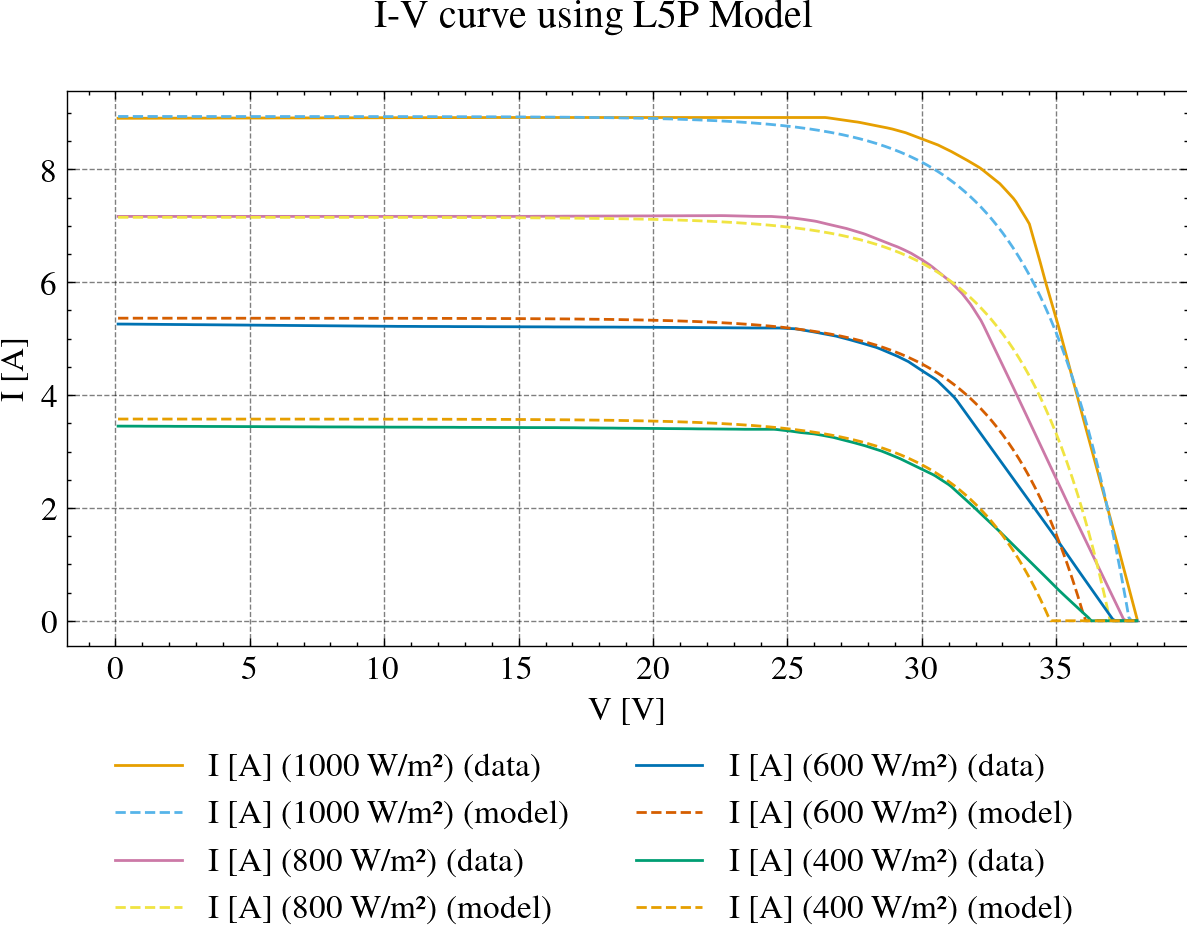

In [35]:
from scipy.special import lambertw
import lmfit

def func_L5P(V_data, G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, a_STC, Boc, Asc, Eg_STC, dEgdT_STC, Tc_STC, G_STC):
    Ipv = np.zeros(V_data.shape)
    for i in range(len(G_data)):
        V = V_data[i]
        G = G_data[i]
        Tc = Tc_data[i]

        # Temperatures [K]
        Tc_K = Tc + 273.15
        Tc_STC_K = Tc_STC + 273.15

        # Compensated Photocurrent [A]
        Iph = (G / G_STC) * (Iph_STC + (Asc * (Tc_K - Tc_STC_K)))

        # Compensated Bandgap energy [eV]
        Eg = Eg_STC * (1.0 + (dEgdT_STC * (Tc_K - Tc_STC_K)))

        # Compensated Non-ideality factor [eV]
        a = a_STC * (Tc_K / Tc_STC_K)

        # Compensated Shockley's dark saturation current [A]
        I0 = I0_STC * ((Tc_K / Tc_STC_K)**3) * (np.exp(Eg_STC / (k*(Tc_STC_K)) - (Eg / (k*(Tc_K)))))

        # Compensated Series resistance [Ohms]
        Rs = Rs_STC * (Tc_K / Tc_STC_K) * (1 - (Boc * np.log(G / G_STC)))

        # Compensated Parallel resistance [Ohms]
        Rp = Rp_STC * (G_STC / G)

        # The equation is:
        #   Ipv = Iph + I0*(np.exp((V + (Rs*Ipv)) / a) -1) - ((V + (Rs*Ipv)) / Rp)
        # To solve it by using LambertW: (ref: https://arxiv.org/pdf/2307.08099.pdf)
        wi = I0*Rp*Rs*np.exp((Rp*(Rs*(Iph + I0) + V))/(a*(Rp + Rs)))/(a*(Rp + Rs))
        wi = lambertw(wi, k=0).real
        Ipv[i] = ((Rp*(Iph + I0) - V)/(Rp+Rs)) - (a/Rs)*wi
        Ipv[i] = np.clip(Ipv[i], a_min=0, a_max=None)

        # wv = (I0*Rp/a) * np.exp( (Rp/a) * (Iph + I0 - Ipv) )
        # wv = lambertw(wv, k=0).real
        # V[i] = Rp*(Iph + I0) - (Rp + Rs)*Ipv - a*wv
        # V[i] = np.clip(V[i], a_min=0, a_max=None)
    return Ipv

model_L5P = lmfit.Model(
    func_L5P,
    independent_vars=['V_data', 'G_data', 'Tc_data'],
    param=['Iph_STC', 'I0_STC', 'Rs_STC', 'Rp_STC', 'a_STC'],
    name='JKM260 L5P',
)

params_L5P = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params_L5P.add_many(
    ('Iph_STC', Iph_0, True, Iph_min, Iph_max, None, None),
    ('I0_STC', I0_0, True, I0_min, I0_max, None, None),
    ('Rs_STC', Rs_0, True, Rs_min, Rs_max, None, None),
    ('Rp_STC', Rp_0, True, Rp_min, Rp_max, None, None),
    ('a_STC', a_0, True, a_min, a_max, None, None),
    ('Boc', Boc, False, None, None, None, None),
    ('Asc', Asc, False, None, None, None, None),
    ('Eg_STC', Eg_STC, False, None, None, None, None),
    ('dEgdT_STC', dEgdT_STC, False, None, None, None, None),
    ('Tc_STC', Tc_STC, False, None, None, None, None),
    ('G_STC', G_STC, False, None, None, None, None),
)

result_L5P = model_L5P.fit(
    data=current_data,
    V_data=voltage_data,
    G_data=irradiation_data,
    Tc_data=temperature_data,
    params=params_L5P,
    method='least_squares',  # Local, fast for this problem
    # method='direct', # Global, also fast for this problem
)

display(result_L5P)

# Aplica o modelo ajustado na função de custo
ydata_fit_L5P = result_L5P.eval()

plt.figure()

for i, G in enumerate(irradiation_data):
    col = f'I [A] ({G} W/m²)'

    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], ydata_fit_L5P[i], '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - ydata_fit_L5P[i]
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

plt.xlabel('V [V]')
plt.ylabel('I [A]')

model_name = 'L5P'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_l5p_opt.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

G: 1000, rmse:  0.3198, mae:  0.202
G:  800, rmse:  0.2751, mae:   0.17
G:  600, rmse:  0.2882, mae:  0.1904
G:  400, rmse:  0.2129, mae:  0.1694


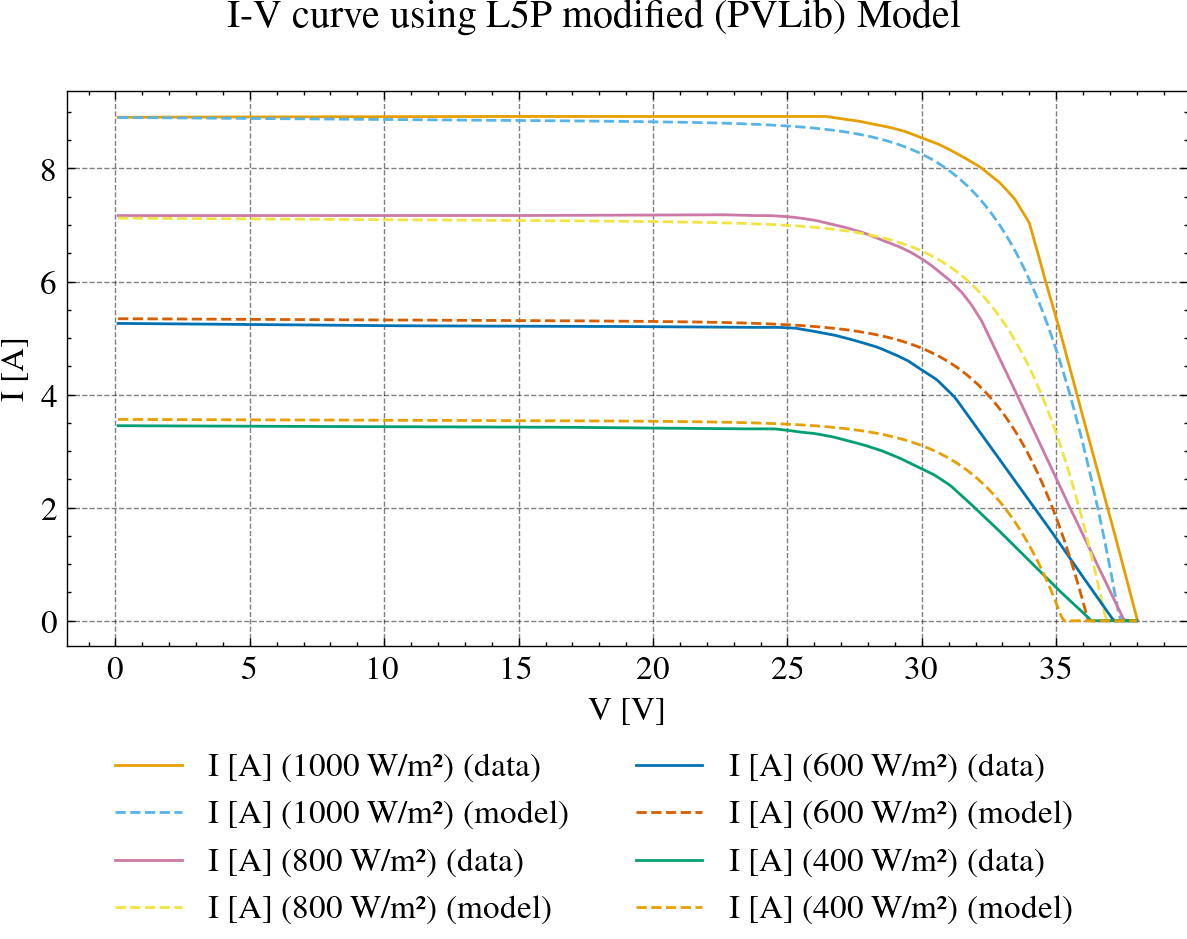

In [36]:
from scipy.special import lambertw
import lmfit

# This is fiting 'n' as parameter and computing 'Vth' and 'a' instead of directly using 'a' as the parameter
def func_L5P_mod(V_data, G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, n, Boc, Asc, Eg_STC, dEgdT_STC, Tc_STC, G_STC):
    # Constants
    K = 1.380649e-23  # Boltzmann [J/K]
    k = 8.617332478e-05  # Boltzmann [eV/K]
    q = 1.602E-19  # Elementary charge [C]

    Ipv = np.zeros(V_data.shape)
    for i in range(len(G_data)):
        V = V_data[i]
        G = G_data[i]
        Tc = Tc_data[i]

        # Temperatures [K]
        Tc_K = Tc + 273.15
        Tc_STC_K = Tc_STC + 273.15

        # Compensated Photocurrent [A]
        Iph = (G / G_STC) * (Iph_STC + (Asc * (Tc_K - Tc_STC_K)))

        # Compensated Bandgap energy [eV]
        Eg = Eg_STC * (1.0 + (dEgdT_STC * (Tc_K - Tc_STC_K)))

        # Compensated Non-ideality factor [eV]
        Vth = K*Tc_K/q
        a = n*Ns*Vth

        # Compensated Shockley's dark saturation current [A]
        I0 = I0_STC * ((Tc_K / Tc_STC_K)**3) * (np.exp(Eg_STC / (k*(Tc_STC_K)) - (Eg / (k*(Tc_K)))))

        # Compensated Series resistance [Ohms]
        Rs = Rs_STC * (Tc_K / Tc_STC_K) * (1 - (Boc * np.log(G / G_STC)))

        # Compensated Parallel resistance [Ohms]
        Rp = Rp_STC * (G_STC / G)

        # The equation is:
        #   Ipv = Iph + I0*(np.exp((V + (Rs*Ipv)) / a) -1) - ((V + (Rs*Ipv)) / Rp)
        # To solve it by using LambertW: (ref: https://arxiv.org/pdf/2307.08099.pdf)
        wi = I0*Rp*Rs*np.exp((Rp*(Rs*(Iph + I0) + V))/(a*(Rp + Rs)))/(a*(Rp + Rs))
        wi = lambertw(wi, k=0).real
        Ipv[i] = ((Rp*(Iph + I0) - V)/(Rp+Rs)) - (a/Rs)*wi
        Ipv[i] = np.clip(Ipv[i], a_min=0, a_max=None)

        # wv = (I0*Rp/a) * np.exp( (Rp/a) * (Iph + I0 - Ipv) )
        # wv = lambertw(wv, k=0).real
        # V[i] = Rp*(Iph + I0) - (Rp + Rs)*Ipv - a*wv
        # V[i] = np.clip(V[i], a_min=0, a_max=None)
    return Ipv

model_L5P_mod = lmfit.Model(
    func_L5P_mod,
    independent_vars=['V_data', 'G_data', 'Tc_data'],
    param=['Iph_STC', 'I0_STC', 'Rs_STC', 'Rp_STC', 'n'],
    name='JKM260 L5P_mod',
)

params_L5P_mod = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params_L5P_mod.add_many(
    ('Iph_STC', Iph_0, True, Iph_min, Iph_max, None, None),
    ('I0_STC', I0_0, True, I0_min, I0_max, None, None),
    ('Rs_STC', Rs_0, True, Rs_min, Rs_max, None, None),
    ('Rp_STC', Rp_0, True, Rp_min, Rp_max, None, None),
    ('n', 1, True, 0.5, 1.5, None, None),
    ('Boc', Boc, False, None, None, None, None),
    ('Asc', Asc, False, None, None, None, None),
    ('Eg_STC', Eg_STC, False, None, None, None, None),
    ('dEgdT_STC', dEgdT_STC, False, None, None, None, None),
    ('Tc_STC', Tc_STC, False, None, None, None, None),
    ('G_STC', G_STC, False, None, None, None, None),
)

result_L5P_mod = model_L5P_mod.fit(
    data=current_data,
    V_data=voltage_data,
    G_data=irradiation_data,
    Tc_data=temperature_data,
    params=params_L5P_mod,
    method='least_squares',  # Local, fast for this problem
    # method='direct', # Global, also fast for this problem
)

display(result_L5P_mod)

# Aplica o modelo ajustado na função de custo
ydata_fit_L5P_mod = result_L5P_mod.eval()

plt.figure()

for i, G in enumerate(irradiation_data):
    col = f'I [A] ({G} W/m²)'

    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], ydata_fit_L5P_mod[i], '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - ydata_fit_L5P_mod[i]
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

plt.xlabel('V [V]')
plt.ylabel('I [A]')

model_name = 'L5P modified (PVLib)'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_l5p_mod_opt.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

G: 1000, rmse:  0.2701, mae:  0.1525
G:  800, rmse:  0.2316, mae:  0.1219
G:  600, rmse:  0.1927, mae:  0.1482
G:  400, rmse:  0.1547, mae:  0.1231


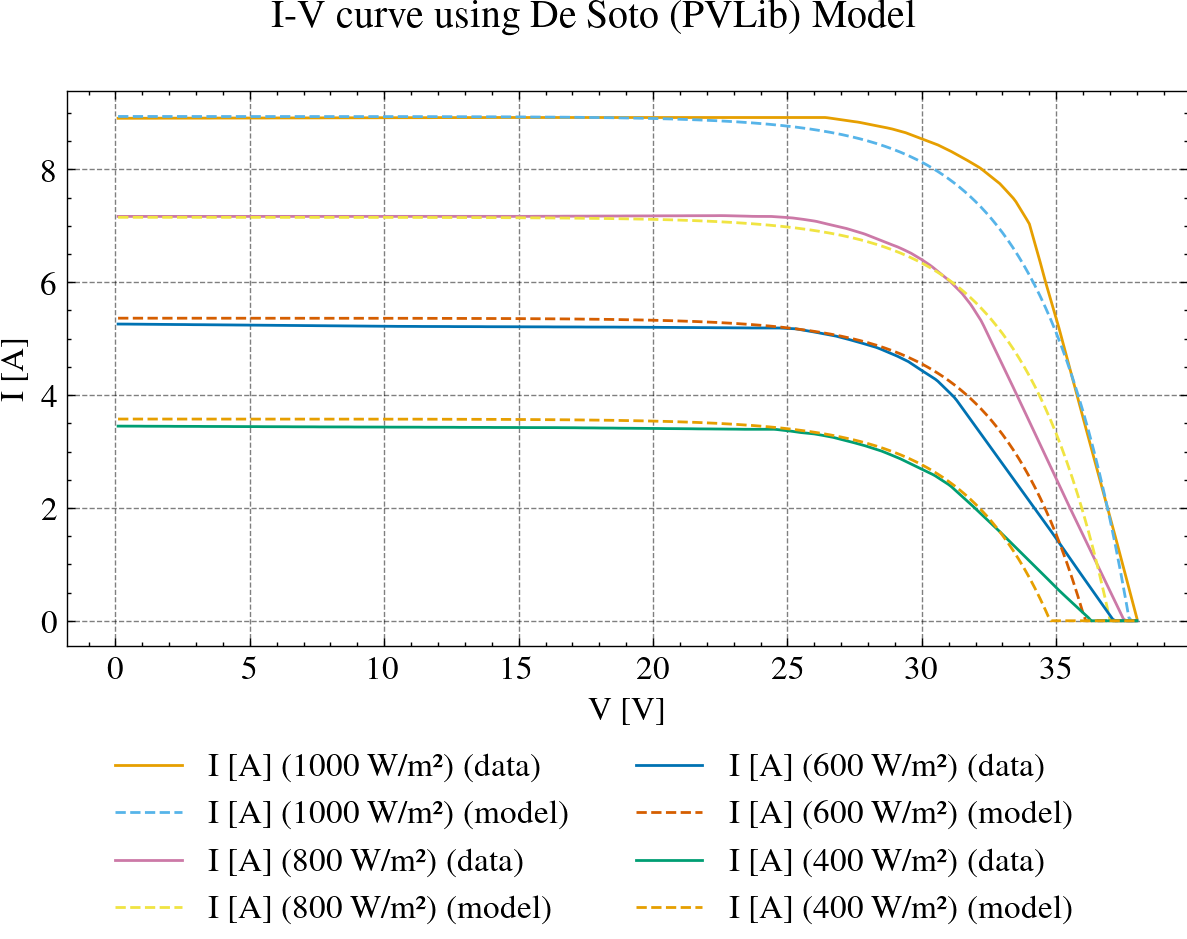

In [37]:
import pvlib
import lmfit

def func_desoto(V_data, G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, a_STC, Asc, Eg_STC, dEgdT_STC, Tc_STC, G_STC):
    Ipv = np.zeros(V_data.shape)
    for i in range(len(G_data)):
        V = V_data[i]
        G = G_data[i]
        Tc = Tc_data[i]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Ipv[i] = np.clip(pvlib.pvsystem.i_from_v(V, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

    return Ipv

model_desoto = lmfit.Model(
    func_desoto,
    independent_vars=['V_data', 'G_data', 'Tc_data'],
    param=['Iph_STC', 'I0_STC', 'Rs_STC', 'Rp_STC', 'a_STC'],
    name='JKM260 desoto',
)


params_desoto = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params_desoto.add_many(
    ('Iph_STC', Iph_0, True, Iph_min, Iph_max, None, None),
    ('I0_STC', I0_0, True, I0_min, I0_max, None, None),
    ('Rs_STC', Rs_0, True, Rs_min, Rs_max, None, None),
    ('Rp_STC', Rp_0, True, Rp_min, Rp_max, None, None),
    ('a_STC', a_0, True, a_min, a_max, None, None),
    ('Asc', Asc, False, None, None, None, None),
    ('Eg_STC', Eg_STC, False, None, None, None, None),
    ('dEgdT_STC', dEgdT_STC, False, None, None, None, None),
    ('Tc_STC', Tc_STC, False, None, None, None, None),
    ('G_STC', G_STC, False, None, None, None, None),
)

result_desoto = model_desoto.fit(
    data=current_data,
    V_data=voltage_data,
    G_data=irradiation_data,
    Tc_data=temperature_data,
    params=params_desoto,
    method='least_squares',  # Local, fast for this problem
    # method='direct', # Global, also fast for this problem
)

display(result_desoto)

# Aplica o modelo ajustado na função de custo
ydata_fit_desoto = result_desoto.eval()

plt.figure()

for i, G in enumerate(irradiation_data):
    col = f'I [A] ({G} W/m²)'

    plt.plot(df['V [V]'], df[col], '-', label=f'{col} (data)')
    plt.plot(df['V [V]'], ydata_fit_desoto[i], '--', label=f'{col} (model)')

    residuals = df[col].to_numpy() - ydata_fit_desoto[i]
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    print(f'G: {G:4}, rmse: {rmse: 6.4}, mae: {mae: 6.4}')

plt.xlabel('V [V]')
plt.ylabel('I [A]')

model_name = 'De Soto (PVLib)'
title_en = f'I-V curve using {model_name} Model'
title_ptg = f'Curva I-V utilizando o Modelo {model_name}'
filename = f'{latex_img_path}/iv_curve_model_desoto_opt.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

### Fitting Desoto to Different Temperature Data

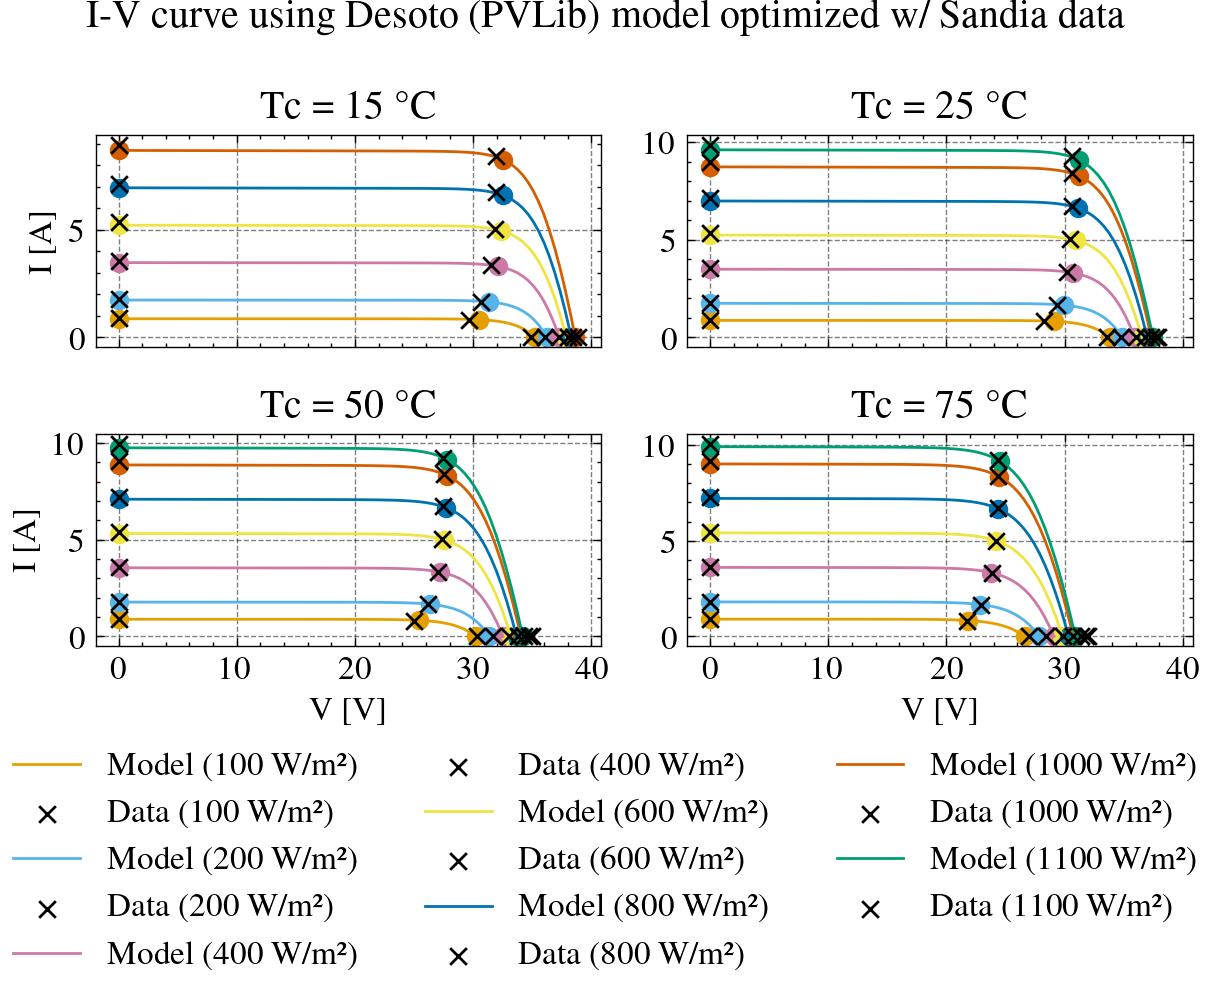

In [38]:
import pvlib
import lmfit

def func_desoto_sandia(G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, a_STC, Asc, Eg_STC, dEgdT_STC, Tc_STC, G_STC):
    Voc = np.zeros(G_data.shape)
    Isc = np.zeros(G_data.shape)
    Vmp = np.zeros(G_data.shape)
    Imp = np.zeros(G_data.shape)
    Pmp = np.zeros(G_data.shape)

    for i in range(len(G_data)):
        G = G_data[i]
        Tc = Tc_data[i]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Isc[i] = pvlib.pvsystem.i_from_v(0, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw')
        Voc[i] = pvlib.pvsystem.v_from_i(0, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw')
        Imp[i], Vmp[i], Pmp[i] = pvlib.pvsystem.max_power_point(photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='brentq').values()

    Voc = np.nan_to_num(Voc)
    Isc = np.nan_to_num(Isc)
    Vmp = np.nan_to_num(Vmp)
    Imp = np.nan_to_num(Imp)
    Pmp = np.nan_to_num(Pmp)

    return Voc, Isc, Vmp, Imp, Pmp

def func_desoto_sandia_i_from_v(V_data, G_data, Tc_data, Iph_STC, I0_STC, Rs_STC, Rp_STC, a_STC, Asc, Eg_STC, dEgdT_STC, Tc_STC, G_STC):
    Ipv = np.zeros(V_data.shape)
    Vpv = np.zeros(V_data.shape)
    for i in range(len(G_data)):
        V = V_data[i]
        G = G_data[i]
        Tc = Tc_data[i]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Ipv[i] = np.clip(pvlib.pvsystem.i_from_v(V, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)
        Vpv[i] = np.clip(pvlib.pvsystem.v_from_i(Ipv[i], photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

    Vpv = np.nan_to_num(Vpv)
    Ipv = np.nan_to_num(Ipv)

    return Vpv, Ipv

model_desoto_sandia = lmfit.Model(
    func_desoto_sandia,
    independent_vars=['G_data', 'Tc_data'],
    param=['Iph_STC', 'I0_STC', 'Rs_STC', 'Rp_STC', 'a_STC'],
    name='JKM260 desoto_sandia',
)

params_desoto_sandia = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params_desoto_sandia.add_many(
    ('Iph_STC', Iph_0, True, Iph_min, Iph_max, None, None),
    ('I0_STC', I0_0, True, I0_min, I0_max, None, None),
    ('Rs_STC', Rs_0, True, Rs_min, Rs_max, None, None),
    ('Rp_STC', Rp_0, True, Rp_min, Rp_max, None, None),
    ('a_STC', a_0, True, a_min, a_max, None, None),
    ('Asc', Asc, False, None, None, None, None),
    ('Eg_STC', Eg_STC, False, None, None, None, None),
    ('dEgdT_STC', dEgdT_STC, False, None, None, None, None),
    ('Tc_STC', Tc_STC, False, None, None, None, None),
    ('G_STC', G_STC, False, None, None, None, None),
)

# Construct the train dataset
columns = {'T (°C)': 'Tc', 'G (W/m2)': 'G', 'Isc (A)': 'Isc', 'Voc (V)': 'Voc', 'Imp (A)': 'Imp', 'Vmp (V)': 'Vmp', 'Pmp (W)': 'Pmp'}
df_sandia = pd.read_csv('dataset/JKM260P-60B-sandia_performance.csv').rename(columns=columns)[columns.values()]
df_sandia = df_sandia.set_index(['G', 'Tc']).sort_index().reset_index()

result_desoto_sandia = model_desoto_sandia.fit(
    data=df_sandia[['Voc', 'Isc', 'Vmp', 'Imp', 'Pmp']].T.to_numpy(),
    G_data=df_sandia['G'].to_numpy(),
    Tc_data=df_sandia['Tc'].to_numpy(),
    params=params_desoto_sandia,
    method='leastsq',  # Local, the best and fastest for this problem
    # method='BFGS',  # also works
    # method='L-BFGS-B'  # also works
)

# EVALUATE with measured points
df_sandia_best = df_sandia[['G', 'Tc']].copy()
df_sandia_best[['Voc', 'Isc', 'Vmp', 'Imp', 'Pmp']] = result_desoto_sandia.best_fit.T

# Test with the a voltage sweep
df_sandia_test_sweep = pd.DataFrame()
voltage_sweep = np.linspace(0, 45, 100, endpoint=False)
df_sandia_test_sweep['V_in'] = np.tile(voltage_sweep, len(df_sandia))
df_sandia_test_sweep['G'] = np.tile(df_sandia['G'].to_numpy(), len(voltage_sweep))
df_sandia_test_sweep['Tc'] = np.tile(df_sandia['Tc'].to_numpy(), len(voltage_sweep))
params = result_desoto_sandia.params.valuesdict()
df_sandia_test_sweep = df_sandia_test_sweep.set_index(['G', 'Tc', 'V_in']).sort_index().reset_index()
res = func_desoto_sandia_i_from_v(df_sandia_test_sweep['V_in'], df_sandia_test_sweep['G'], df_sandia_test_sweep['Tc'], **params)
df_sandia_test_sweep['V'] = res[0]
df_sandia_test_sweep['I'] = res[1]
G_list = df_sandia_test_sweep['G'].unique()
Tc_list = df_sandia_test_sweep['Tc'].unique()

df_sandia = df_sandia.set_index(['G', 'Tc']).sort_index()
df_sandia_test_sweep = df_sandia_test_sweep.set_index(['G', 'Tc']).sort_index()
df_sandia_best = df_sandia_best.set_index(['G', 'Tc']).sort_index()

# Plot results
fig, axes = plt.subplots(2, 2, figsize=figsize('abntex2', subplots=(2, 2)), sharex=True, sharey=False)

for Tc, ax in zip(Tc_list, axes.flatten()):
    ax.set_title(f'Tc = {Tc} °C')
    for G in G_list:
        if (G, Tc) not in df_sandia.index:
            continue

        model_sweep_data = df_sandia_test_sweep.loc[(G, Tc)]
        ax.plot(model_sweep_data['V'], model_sweep_data['I'], ls='solid', label=f'Model ({G} W/m²)')

        model_data = df_sandia_best.loc[(G, Tc)]
        vi_points = np.array([
            [0, model_data['Isc']],
            [model_data['Vmp'], model_data['Imp']],
            [model_data['Voc'], 0],
        ]).T
        ax.scatter(vi_points[0], vi_points[1], marker='o')

        sandia_data = df_sandia.loc[(G, Tc)]
        vi_points = np.array([
            [0, sandia_data['Isc']],
            [sandia_data['Vmp'], sandia_data['Imp']],
            [sandia_data['Voc'], 0],
        ]).T
        ax.scatter(vi_points[0], vi_points[1], marker='x', color='black', zorder=100, label=f'Data ({G} W/m²)')

# Set labels
axes[-1,0].set_xlabel('V [V]')
axes[-1,-1].set_xlabel('V [V]')
axes[0,0].set_ylabel('I [A]')
axes[-1,0].set_ylabel('I [A]')

model_name = 'Desoto (PVLib)'
title_en = f'I-V curve using {model_name} model optimized w/ Sandia data'
title_ptg = f'Curva I-V utilizando o Modelo {model_name} otimizado com os dados da Sandia'
filename = f'{latex_img_path}/iv_curve_model_mpp_opt.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=3)

display(result_desoto_sandia)

ydata_fit_desoto_sandia = func_desoto(V_data=voltage_data, G_data=irradiation_data, Tc_data=temperature_data, **params)

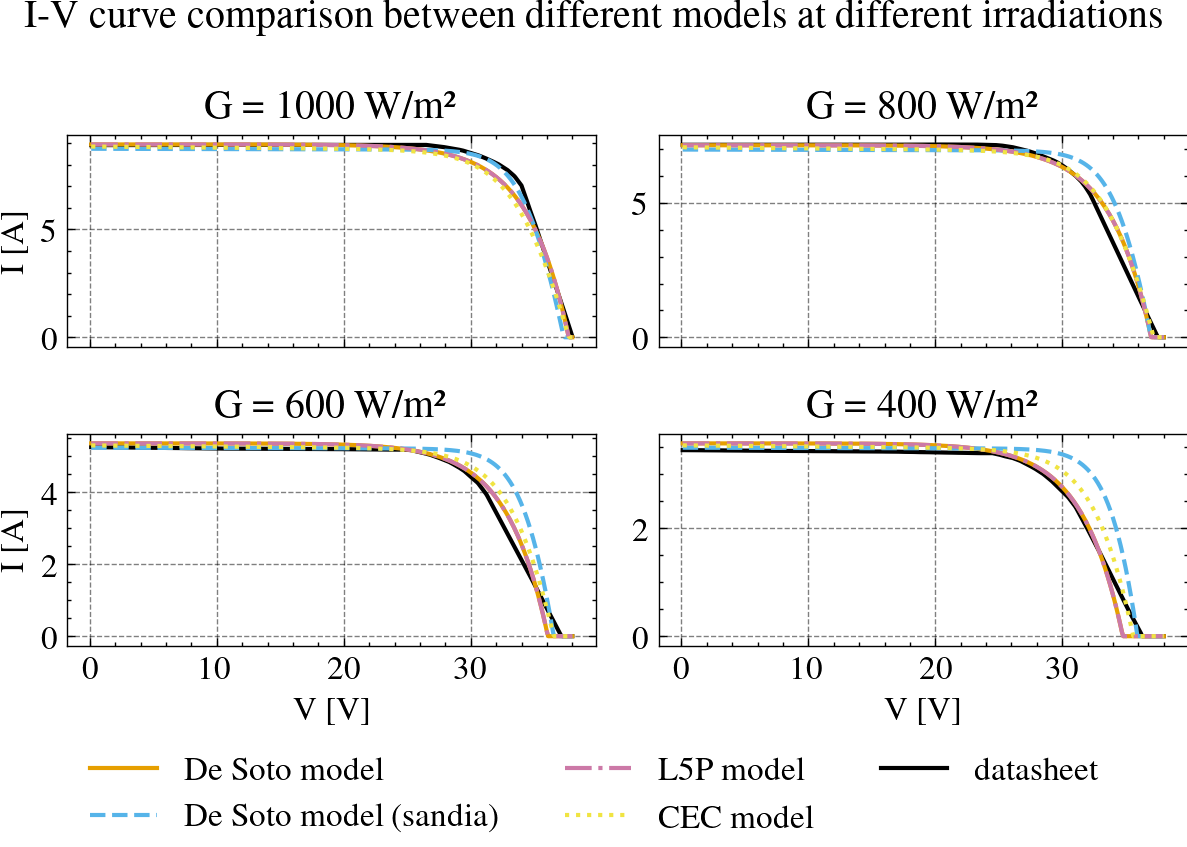

In [39]:
fig, axes = plt.subplots(2, 2, figsize=figsize('abntex2', subplots=(2, 2)), sharex=True, sharey=False)

for i, (G, ax) in enumerate(zip(irradiation_data, axes.flatten())):
    col = f'I [A] ({G} W/m²)'

    ax.plot(df['V [V]'], ydata_fit_desoto[i], lw=1.5, label='De Soto model')
    ax.plot(df['V [V]'], ydata_fit_desoto_sandia[i], lw=1.5, label='De Soto model (sandia)')
    ax.plot(df['V [V]'], ydata_fit_L5P[i], lw=1.5, label='L5P model')
    ax.plot(df['V [V]'], ydata_fit_CEC[i], lw=1.5, label='CEC model')
    ax.plot(df['V [V]'], df[col], lw=1.5, zorder=0, color='black', ls='solid', label='datasheet')

    ax.set_title(f'G = {G} W/m²')

# Set labels
axes[-1,0].set_xlabel('V [V]')
axes[-1,-1].set_xlabel('V [V]')
axes[0,0].set_ylabel('I [A]')
axes[-1,0].set_ylabel('I [A]')

title_en = 'I-V curve comparison between different models at different irradiations'
title_ptg = 'Comparação da Curva I-V entre Modelos Diferentes em Diferentes Irradiações'
filename = f'{latex_img_path}/iv_curve_models_comparison.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=3)

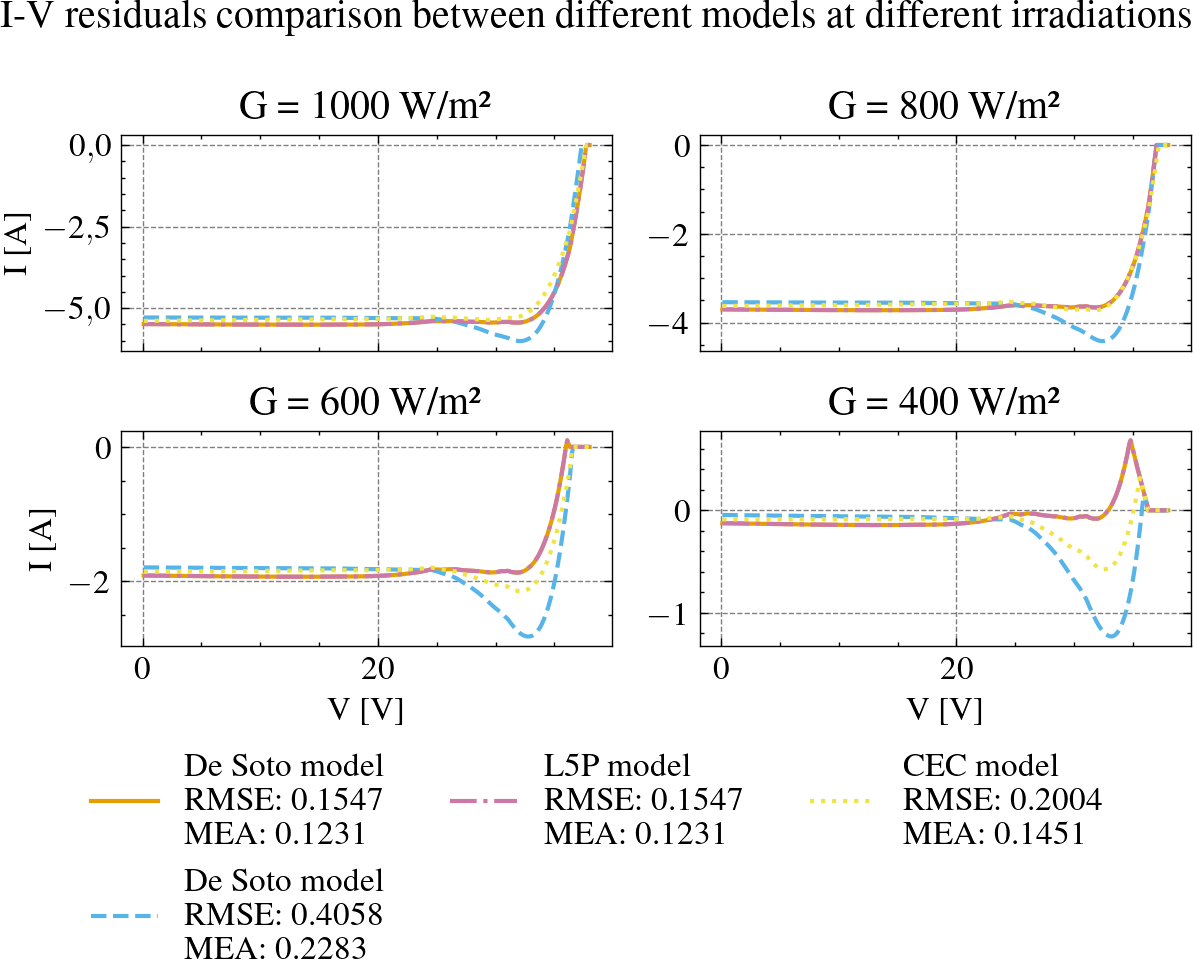

In [40]:
fig, axes = plt.subplots(2, 2, figsize=figsize('abntex2', subplots=(2, 2)), sharex=True, sharey=False)

for i, (G, ax) in enumerate(zip(irradiation_data, axes.flatten())):
    for model, ydata in [('De Soto', ydata_fit_desoto[i]), ('De Soto', ydata_fit_desoto_sandia[i]), ('L5P', ydata_fit_L5P[i]), ('CEC', ydata_fit_CEC[i])]:

        residuals = df[col].to_numpy() - ydata
        rmse = np.sqrt(np.mean(np.square(residuals)))
        mae = np.mean(np.abs(residuals))

        ax.plot(df['V [V]'], residuals, lw=1.5, label=f'{model} model\nRMSE: {rmse:.4f}\nMEA: {mae:.4f}')

    ax.set_title(f'G = {G} W/m²')

# Set labels
axes[-1,0].set_xlabel('V [V]')
axes[-1,-1].set_xlabel('V [V]')
axes[0,0].set_ylabel('I [A]')
axes[-1,0].set_ylabel('I [A]')

title_en = 'I-V residuals comparison between different models at different irradiations'
title_ptg = 'Comparação dos Resíduos I-V entre Modelos Diferentes em Diferentes Irradiações'
filename = f'{latex_img_path}/iv_curve_models_comparison_residuals.pdf'

fig_save_and_show(filename, title_ptg, title_en, ncol=3)

# Generation Model

### Load data from the boat

In [41]:
from pytz import timezone
import vaex

tzinfo = timezone('America/Sao_Paulo')

events = [
    {
        'name': '01.Curta',
        'start': pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        'name': '02.Longa',
        'start': pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        'name': '03.Revezamento',
        'start': pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        'name': '04.Curta',
        'start': pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        'name': '05.Curta',
        'start': pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        'name': '07.Sprint',
        'start': pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        'end': pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
start, end = events.loc['05.Curta']

start = pd.Timestamp(
    year=2020, month=2, day=1, hour=13, minute=00, second=00, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=2, day=1, hour=15, minute=30, second=00, tzinfo=tzinfo
).tz_convert(None)

'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Motor Angular Speed': 'motor_wm',
 'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['motor_wm', 'batt_v', 'batt_i', 'mppt1_ii', 'mppt1_vi', 'mppt1_d',
       'mppt1_io', 'solar_poa', 'wind_v', 'air_t'],
      dtype='object')

<Figure size 1259.84x778.626 with 0 Axes>

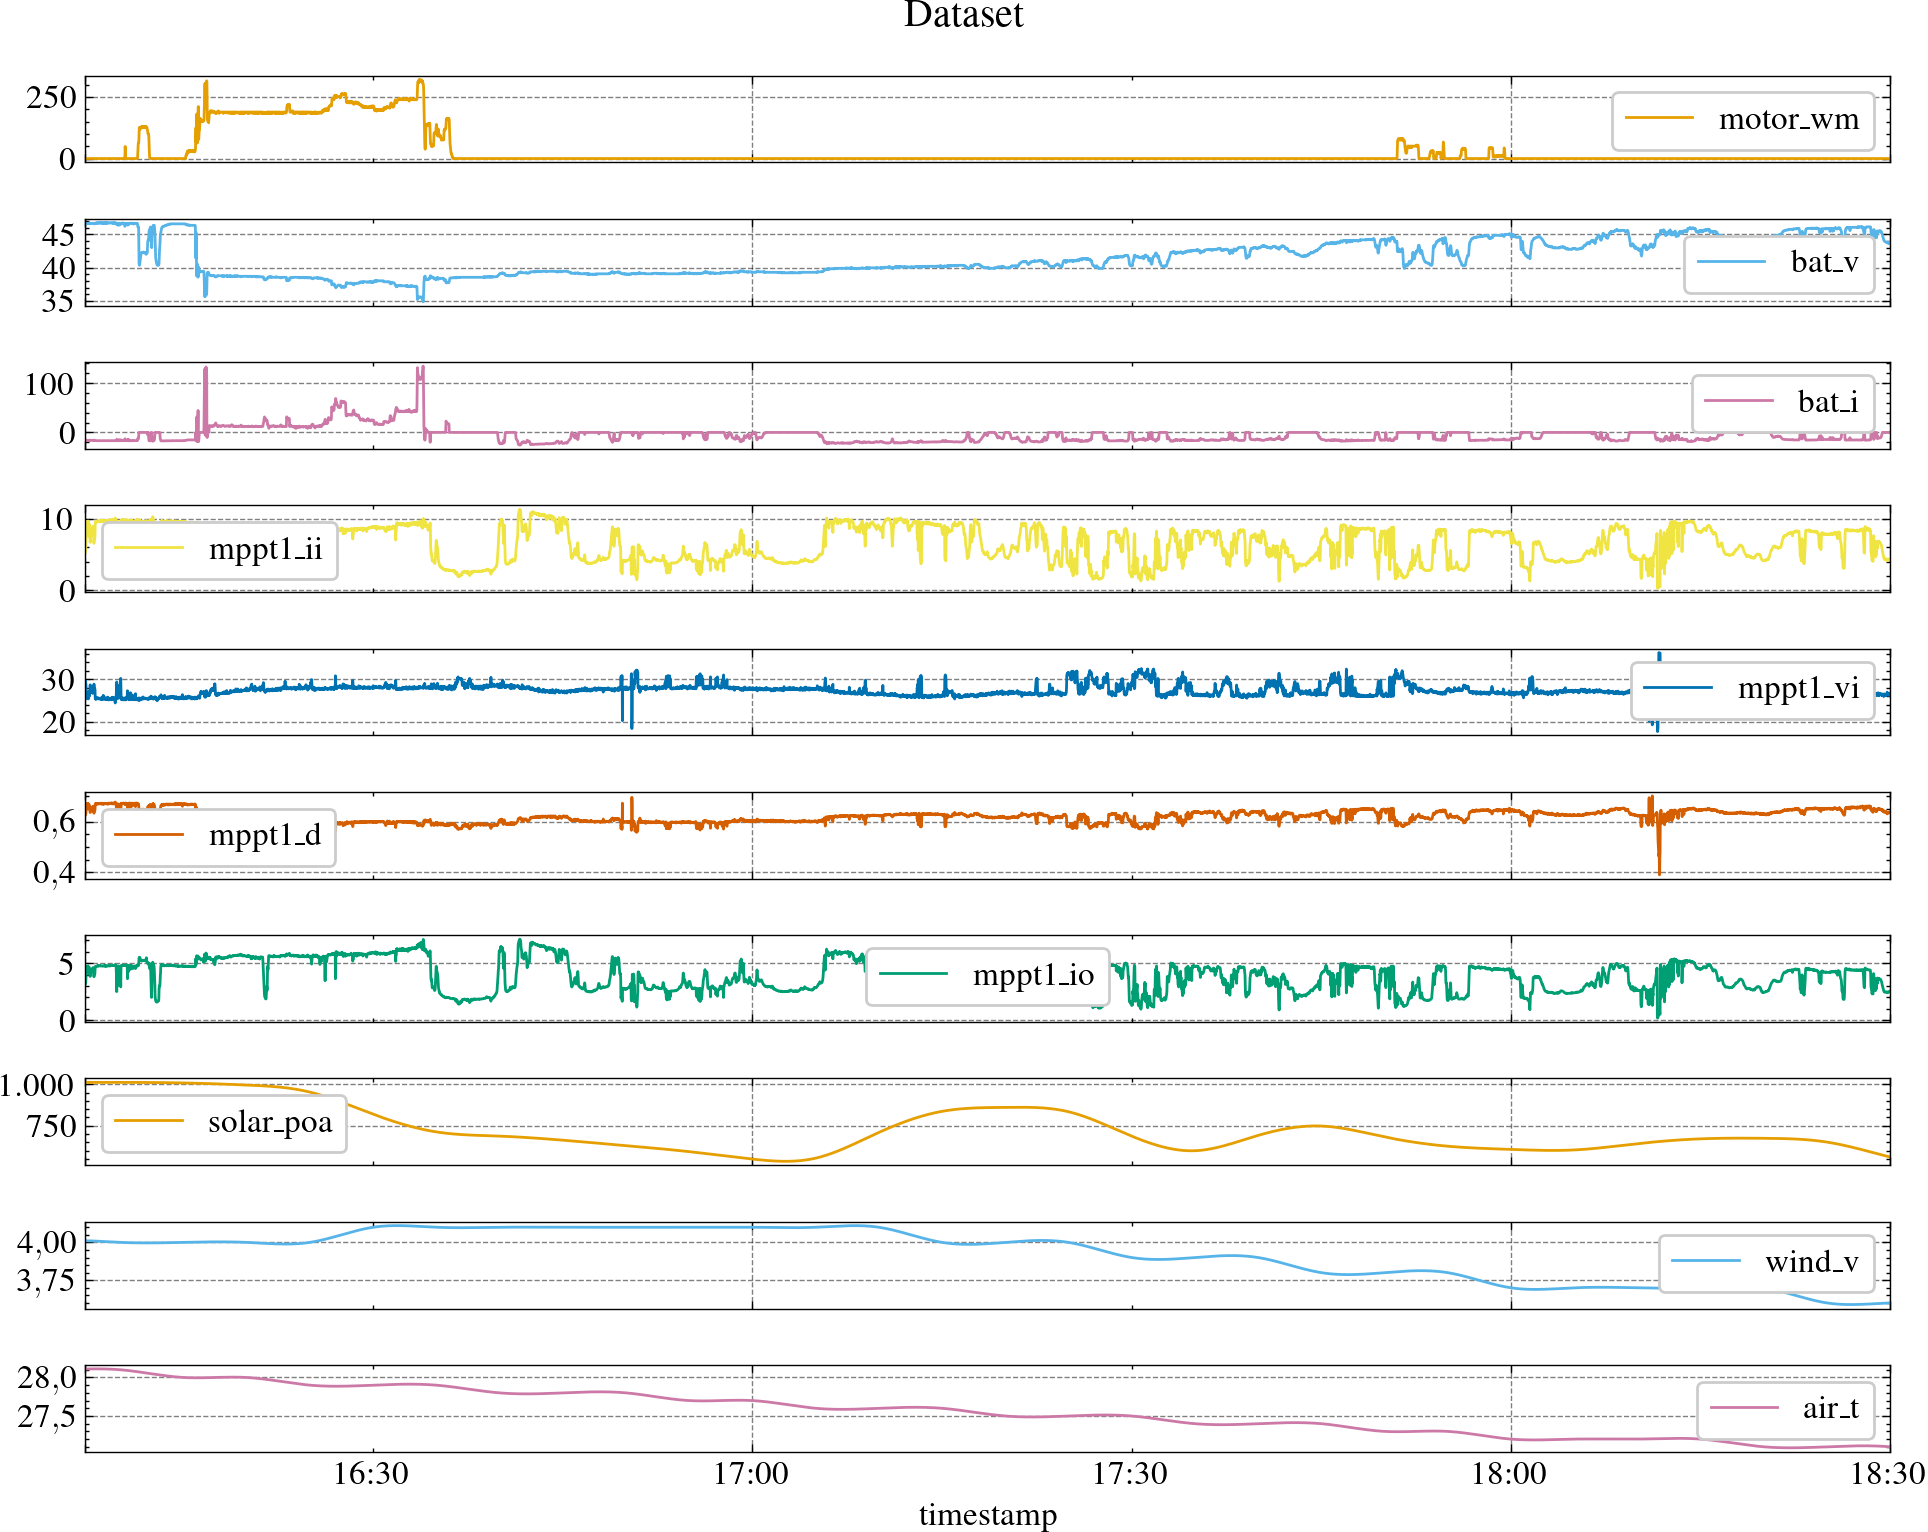

In [42]:
# # From Revezamento
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
# ).tz_convert(None)

df = vaex.from_csv('../../../models/2020/boat_data_1s.csv').to_pandas_df()
# df = vaex.from_csv('../../../models/2020/boat_data_100ms.csv').to_pandas_df()
df['timestamp'] = pd.DatetimeIndex(df['timestamp']).tz_convert(None)
df = df.set_index('timestamp')
display('original columns:', df.columns)

renamed_columns = {
    'Motor Angular Speed': 'motor_wm',
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'MPPT 1 Input Current': 'mppt1_ii',
    'MPPT 1 Input Voltage': 'mppt1_vi',
    'MPPT 1 Duty Cycle': 'mppt1_d',
    # 'MPPT 1 Output Voltage': 'mppt1_vo',
    'MPPT 1 Output Current': 'mppt1_io',
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.resample('1s').mean().interpolate(method='time', limit_area='inside')
# df = df.resample('10min').mean().interpolate(method='time', limit_area='inside')

df = df.dropna()

plt.figure()
df.plot(subplots=True, figsize=(10, 8))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

### Helper function

In [43]:
import control as ct

def input_output_response_to_pandas(response: ct.input_output_response):
    # until this gets merged: https://github.com/python-control/python-control/issues/957
    data = {'time': response.time}
    if response.ninputs > 0:
        data.update(
            {name: response.inputs[i] for i, name in enumerate(response.input_labels)})
    if response.noutputs > 0:
        data.update(
            {name: response.outputs[i] for i, name in enumerate(response.output_labels)})
    if response.nstates > 0:
        data.update(
            {name: response.states[i] for i, name in enumerate(response.state_labels)})
    return pd.DataFrame(data)

### Solar Panel

In [44]:
solar_panel = ct.interconnect(
    (
        ct.rss(name='pv_diode_model', inputs=('G', 'Tc', 'I'), outputs=('V',)),
        ct.rss(name='pv_thermal_model', inputs=('G', 'Ta', 'vw'), outputs=('Tc',)),
    ),
    name='solar_panel',
    connections=(
        ('pv_diode_model.Tc', 'pv_thermal_model.Tc'),
    ),
    inplist=(['pv_thermal_model.G', 'pv_diode_model.G'], 'pv_thermal_model.Ta', 'pv_thermal_model.vw', 'pv_diode_model.I'),
    inputs=('G', 'Ta', 'vw', 'I'),
    outlist=('pv_diode_model.V',),
    outputs=('V',),
)
solar_panel


<LinearICSystem:solar_panel:['G', 'Ta', 'vw', 'I']->['V']>

#### Diode Model

<NonlinearIOSystem:pv_diode_model:['G', 'Tc', 'V']->['I']>

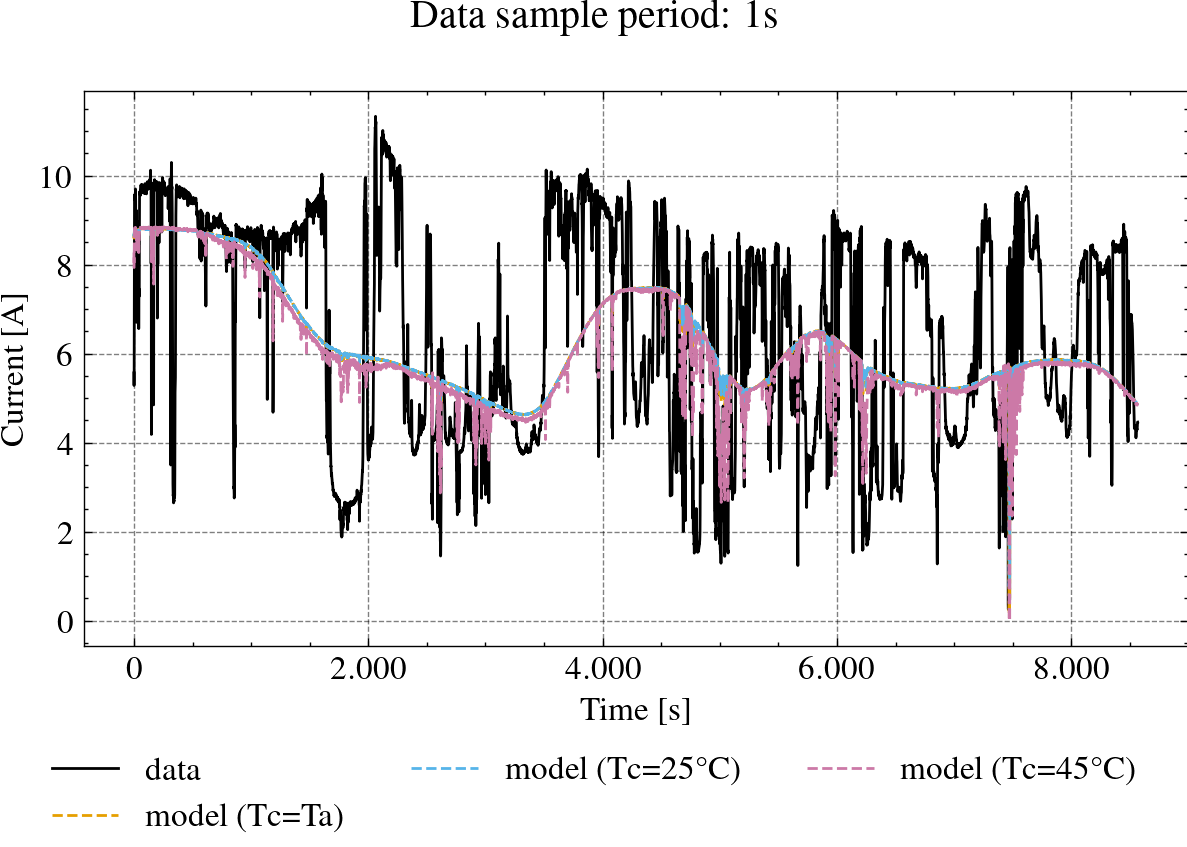

period: 1s
rmse: 2.177789039465851
mae: 1.7960297320615652



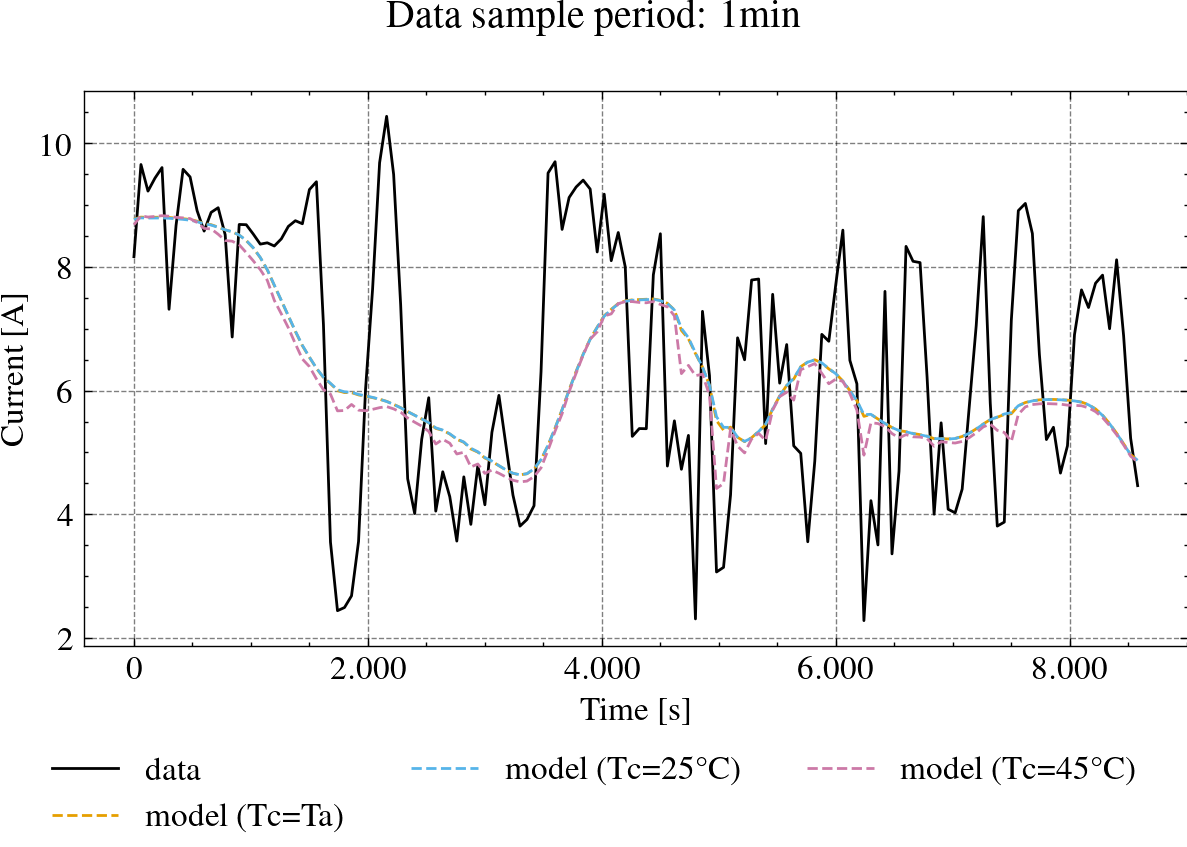

period: 1min
rmse: 1.8490952341119524
mae: 1.4982173902930258



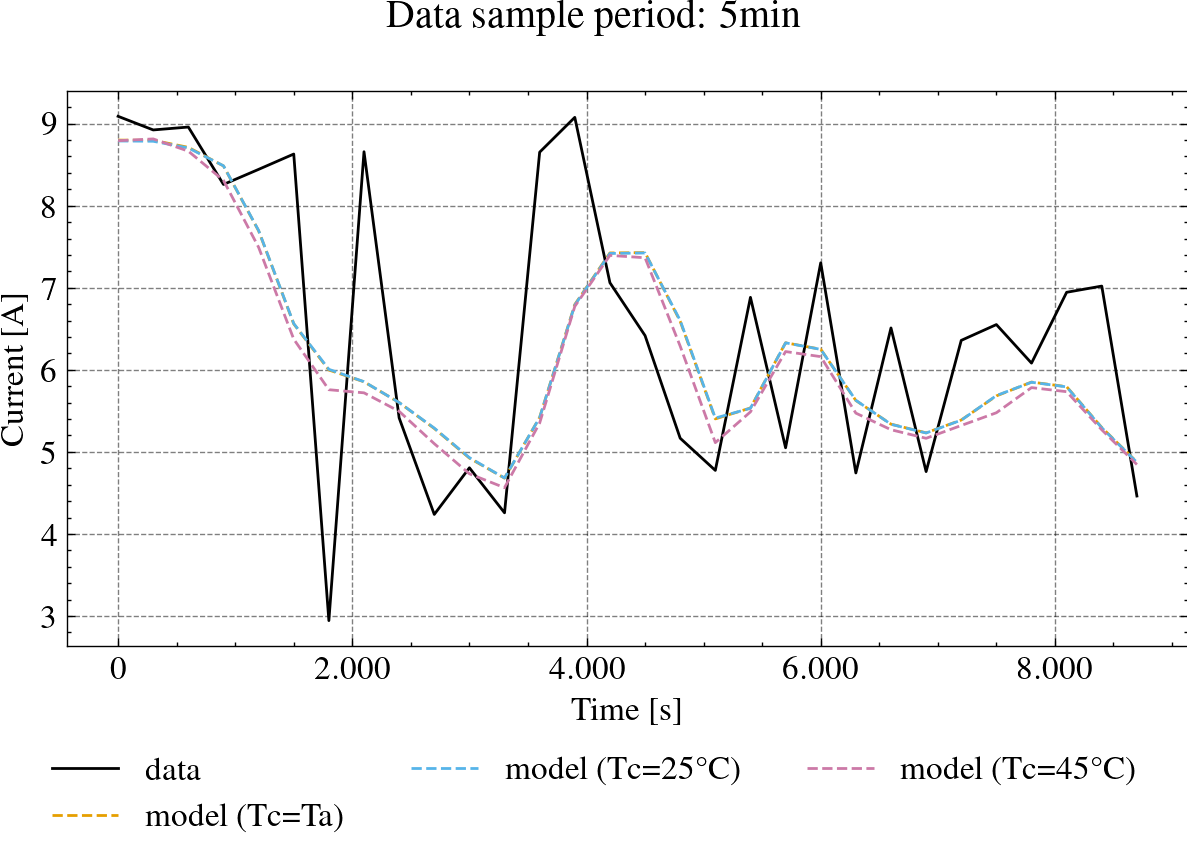

period: 5min
rmse: 1.3656150844635693
mae: 1.0615067491890886



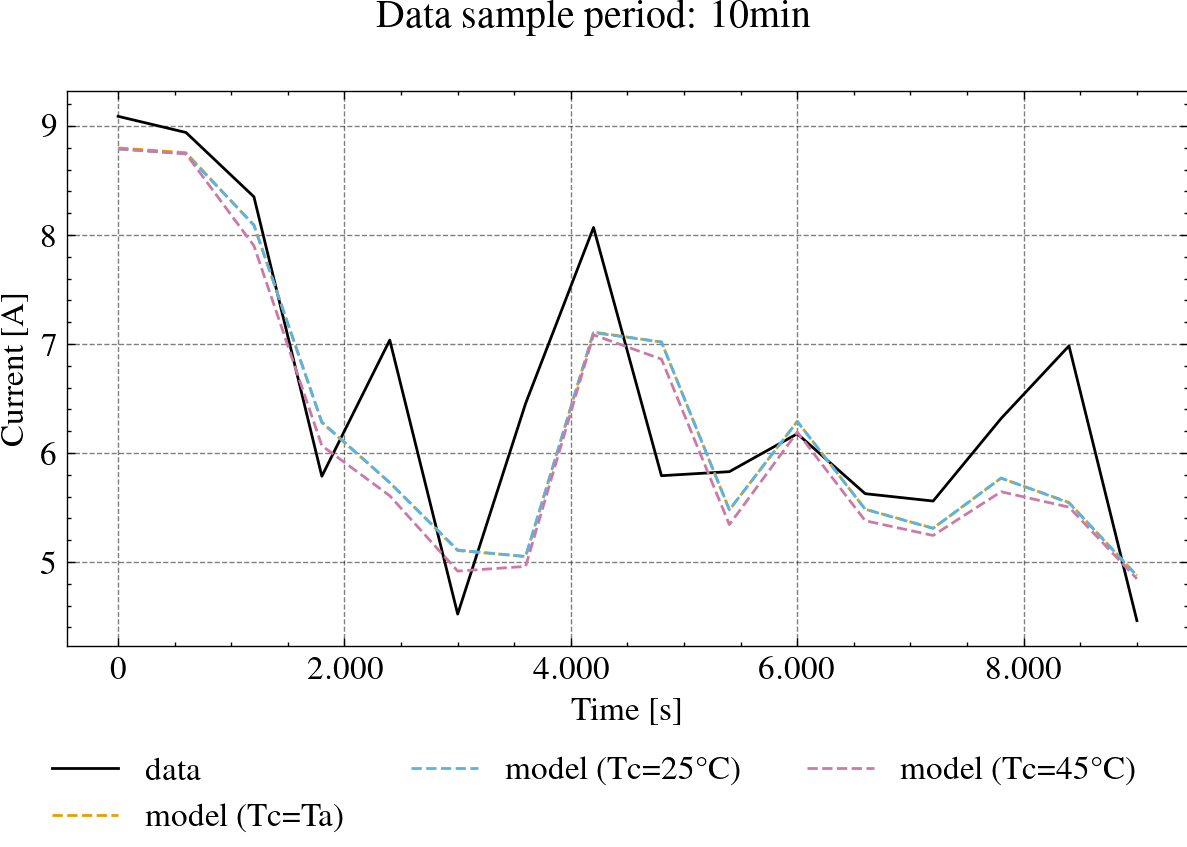

period: 10min
rmse: 0.7756293628974761
mae: 0.6226422259614612



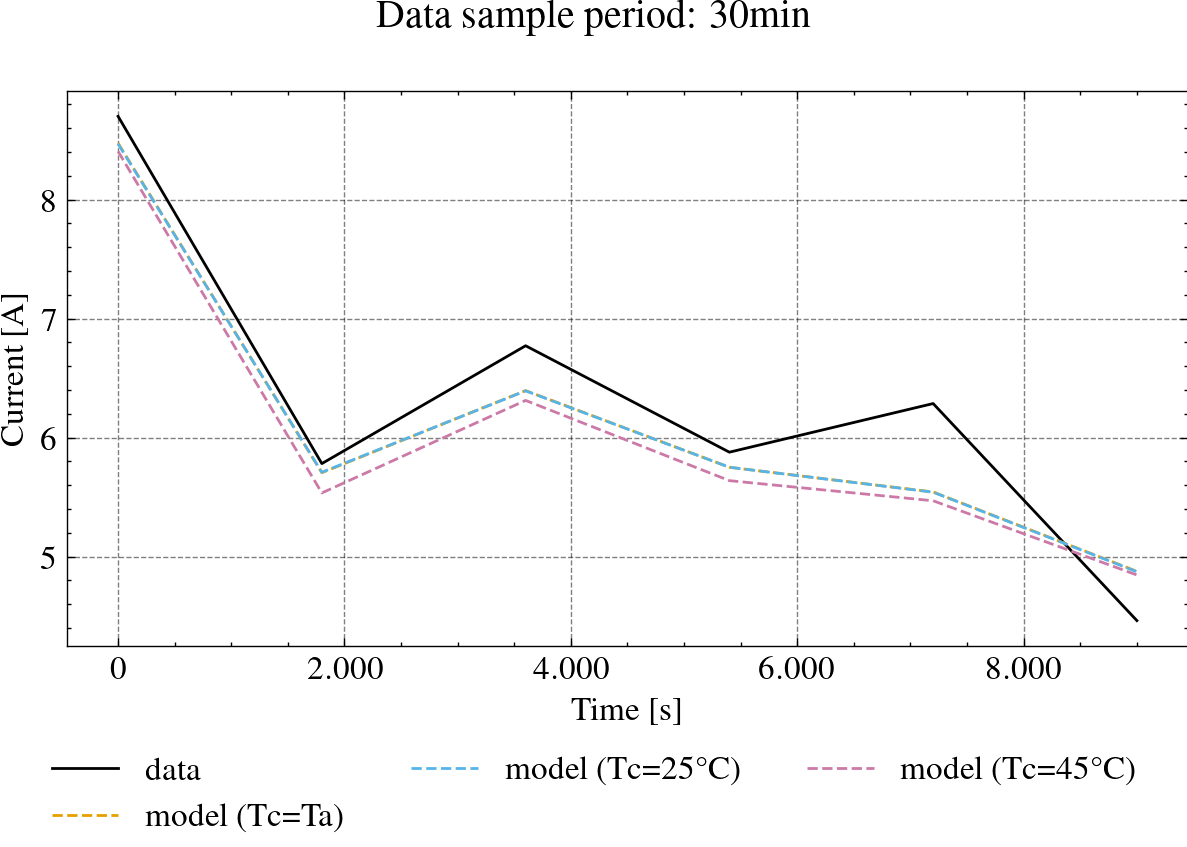

period: 30min
rmse: 0.3954513967629654
mae: 0.32715858364435285



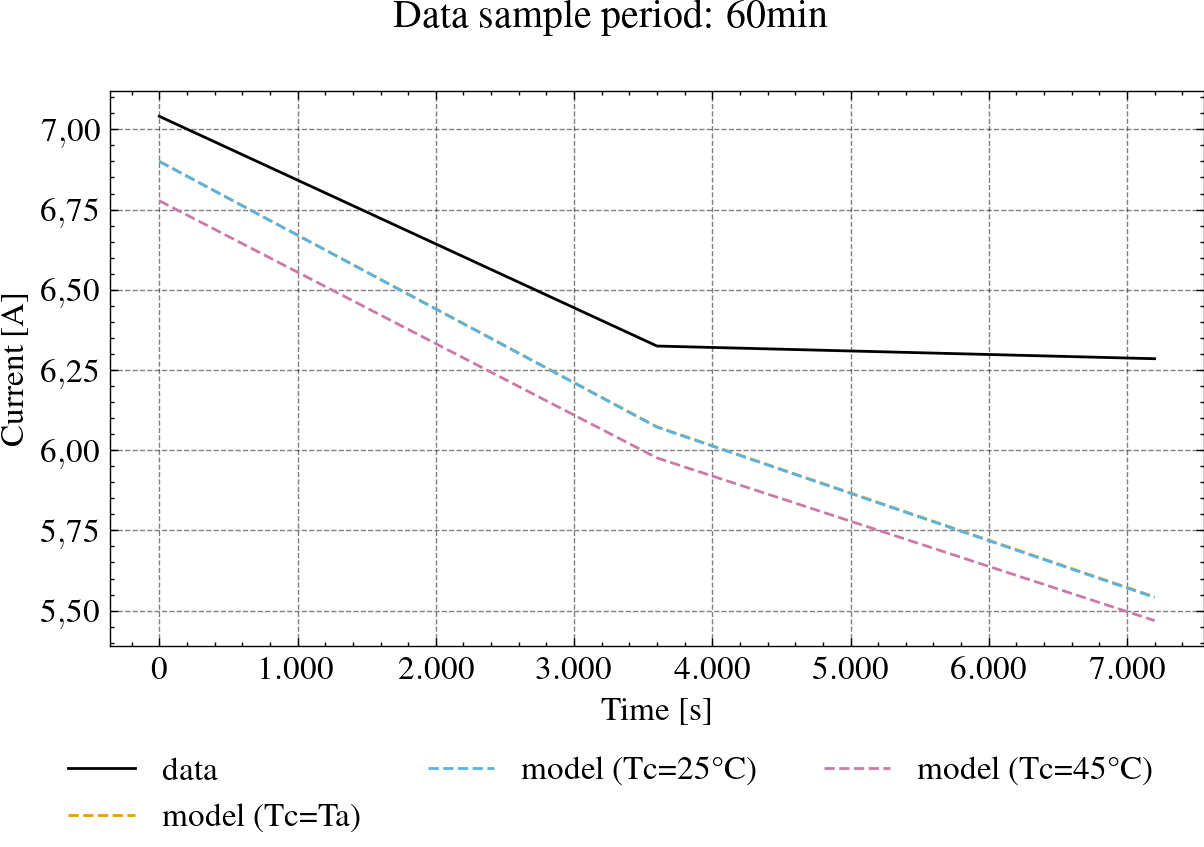

period: 60min
rmse: 0.45978690613657097
mae: 0.3781394731993923



In [45]:
import pvlib
import control as ct

class SolarPanelDiodeModel:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']

        # Inputs
        G = u[0]
        Tc = u[1]
        Vpv = u[2]

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        return np.clip(pvlib.pvsystem.i_from_v(Vpv, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="pv_diode_model",
            states=None,
            inputs=('G', 'Tc', 'V'),
            outputs=('I',),
            params=params,
        )


pv_diode_params = {f'pv_{k}':v for (k,v) in result_desoto_sandia.params.valuesdict().items()}

pv_diode = SolarPanelDiodeModel.build(pv_diode_params)
display(pv_diode)

dfa = df.copy()
for period in ['1s', '1min', '5min', '10min', '30min', '60min']:
    df = dfa.resample(period).mean().interpolate(method='time', limit_area='inside')

    # Time array
    T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
    lenT = len(df.index)
    T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

    # Data
    U = np.array([
        df['solar_poa'].to_numpy(),
        df['air_t'].to_numpy(),
        df['mppt1_vi'].to_numpy(),
    ])
    res = ct.input_output_response(pv_diode, T=T, U=U, solve_ivp_method="Radau")
    ydata = input_output_response_to_pandas(res)

    plt.figure()
    plt.plot(T, df['mppt1_ii'], ls='-', color='black', label='data')
    plt.plot(T, ydata['I'], ls='--', label='model (Tc=Ta)')

    for Tc in [25, 45]:
        U = np.array([
            df['solar_poa'].to_numpy(),
            np.ones(len(T)) * Tc,
            df['mppt1_vi'].to_numpy(),
        ])
        res_ = ct.input_output_response(pv_diode, T=T, U=U, solve_ivp_method="Radau")
        ydata_ = input_output_response_to_pandas(res_)
        plt.plot(T, ydata_['I'], ls='--', label=f'model (Tc={Tc}°C)')

    plt.xlabel('Time [s]')
    plt.ylabel('Current [A]')
    title_ptg = title_en = f'Data sample period: {period}'
    filename = '/tmp/tmp_plot.pdf'
    fig_save_and_show(filename, title_ptg, title_en, ncol=3)

    col = 'mppt1_ii'
    residuals = df[col].to_numpy() - ydata['I'].to_numpy()
    residuals = residuals[~np.isnan(residuals)]
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))

    print('period:', period)
    print('rmse:', rmse)
    print('mae:', mae)
    print('')

    # plt.figure()
    # plt.plot(residuals, label=f'model\nRMSE: {rmse:.4f}\nMEA: {mae:.4f}')
    # fig_save_and_show(filename, title_ptg, title_en, ncol=4)
df = dfa


In [46]:
df = dfa
# df = df.resample('1min').mean().interpolate(method='time', limit_area='inside')

#### Thermal Model

<NonlinearIOSystem:pv_thermal_model:['G', 'Ta', 'vw']->['Tc']>

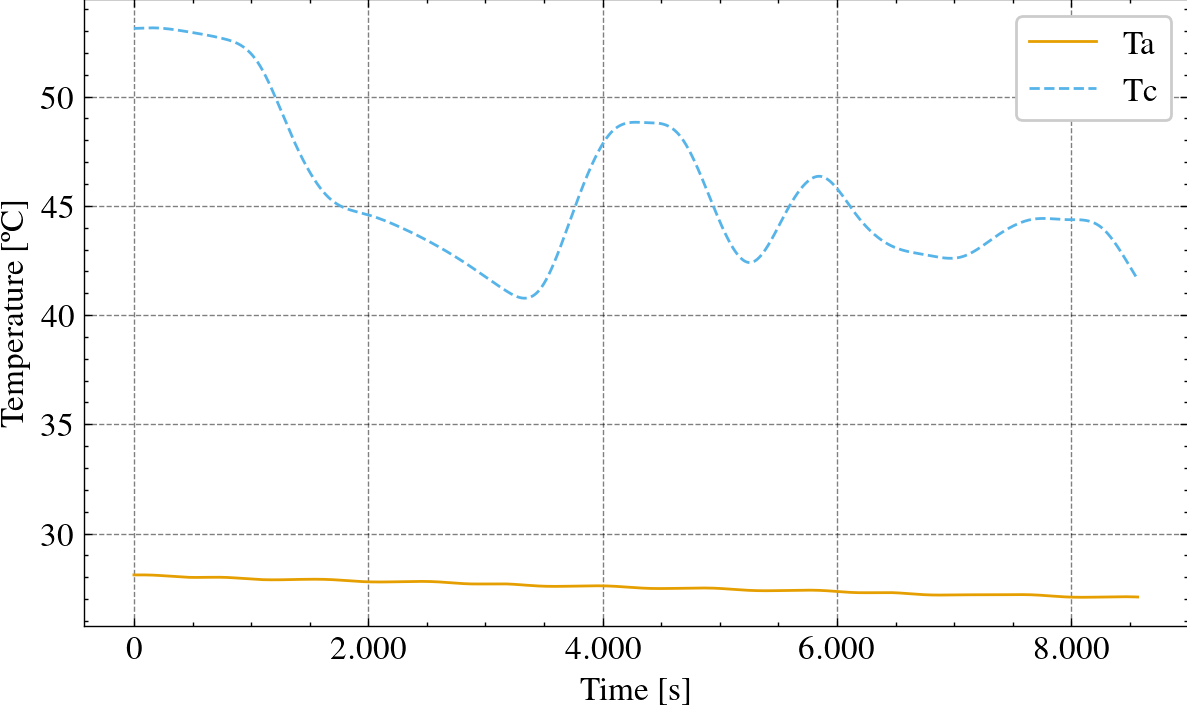

In [47]:
class PVCellThermalModel:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        return pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="pv_thermal_model",
            states=None,
            inputs=('G', 'Ta', 'vw'),
            outputs=('Tc',),
            params=params,
        )

u0 = np.array([21.99, 22.71, 23.37, 24.06, 22.61, 23.13, 21.95, 21.70]).mean()
u1 = np.array([3.83, 3.72, 3.91, 3.55, 4.68, 4.24, 5.23, 6.24]).mean()
# print(u0, u1)

pv_th_params = {
    'pv_th_alpha': 0.88,
    'pv_th_u0': u0, #25.0,
    'pv_th_u1': u1, #6.84,
}

pv_th = PVCellThermalModel.build(pv_th_params)
display(pv_th)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v']].to_numpy().T

res = ct.input_output_response(pv_th, T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)

plt.figure(figsize=figsize('abntex2'))
plt.plot(T, df['air_t'], label='Ta')
plt.plot(T, ydata['Tc'], label='Tc')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [ºC]')
plt.legend()
plt.tight_layout()
plt.show()

#### Solar Panel

<InterconnectedSystem:solar_panel:['G', 'Ta', 'vw', 'V']->['I']>

Index(['time', 'G', 'Ta', 'vw', 'V', 'I'], dtype='object')
rmse: 2.132387030939128
mae: 1.761307590841037


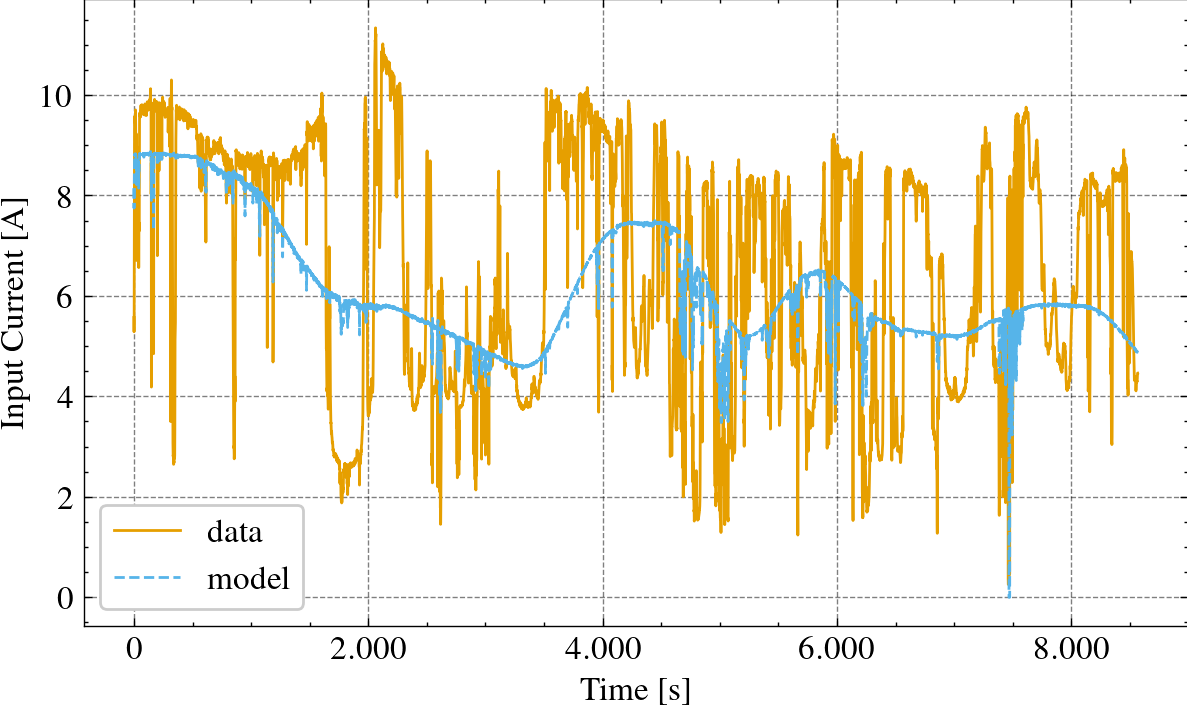

In [48]:
class SolarPanel:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.interconnect(
            (
                SolarPanelDiodeModel.build(params),
                PVCellThermalModel.build(params),
            ),
            name='solar_panel',
            connections=(
                ('pv_diode_model.Tc', 'pv_thermal_model.Tc'),
            ),
            inplist=(['pv_thermal_model.G', 'pv_diode_model.G'], 'pv_thermal_model.Ta', 'pv_thermal_model.vw', 'pv_diode_model.V'),
            inputs=('G', 'Ta', 'vw', 'V'),
            outlist=('pv_diode_model.I',),
            outputs=('I',),
        )

pv_params = pv_diode_params.copy()
pv_th_params = {
    'pv_th_alpha': 0.88,
    'pv_th_u0': 25.0,
    'pv_th_u1': 6.84,
}
pv_params |= pv_th_params

solar_panel = SolarPanel.build(pv_params)
display(solar_panel)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'mppt1_vi']].to_numpy().T

res = ct.input_output_response(solar_panel, T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)
print(ydata.columns)

residuals = df['mppt1_ii'].to_numpy() - ydata['I'].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure(figsize=figsize('abntex2'))
plt.plot(T, df['mppt1_ii'], label='data')
plt.plot(T, ydata['I'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Input Current [A]')
plt.legend()
plt.tight_layout()
plt.show()

### MPPT

In [49]:
mppt = ct.interconnect(
    (
        ct.rss(name='mppt_p_outwer', inputs=('D', 'Ii', 'Vo'), outputs=('Vi', 'Io')),
        ct.rss(name='mppt_controller', inputs=('G', 'Ta', 'vw', 'Vpv', 'Vbat'), outputs=('D',)),
    ),
    name='mppt',
    connections=(
        ('mppt_p_outwer.D', 'mppt_controller.D'),
        ('mppt_controller.Vpv', 'mppt_p_outwer.Vi'),
    ),
    inplist=('mppt_controller.G', 'mppt_controller.Ta', 'mppt_controller.vw', ['mppt_controller.Vbat', 'mppt_p_outwer.Vo'], 'mppt_p_outwer.Ii'),
    inputs=('G', 'Ta', 'vw', 'Vo', 'Ii'),
    outlist=('mppt_p_outwer.Vi', 'mppt_p_outwer.Io'),
    outputs=('Vi', 'Io'),
)
display(mppt)


<LinearICSystem:mppt:['G', 'Ta', 'vw', 'Vo', 'Ii']->['Vi', 'Io']>

rmse: 0.7717483986834207
mae: 0.25911892143969034


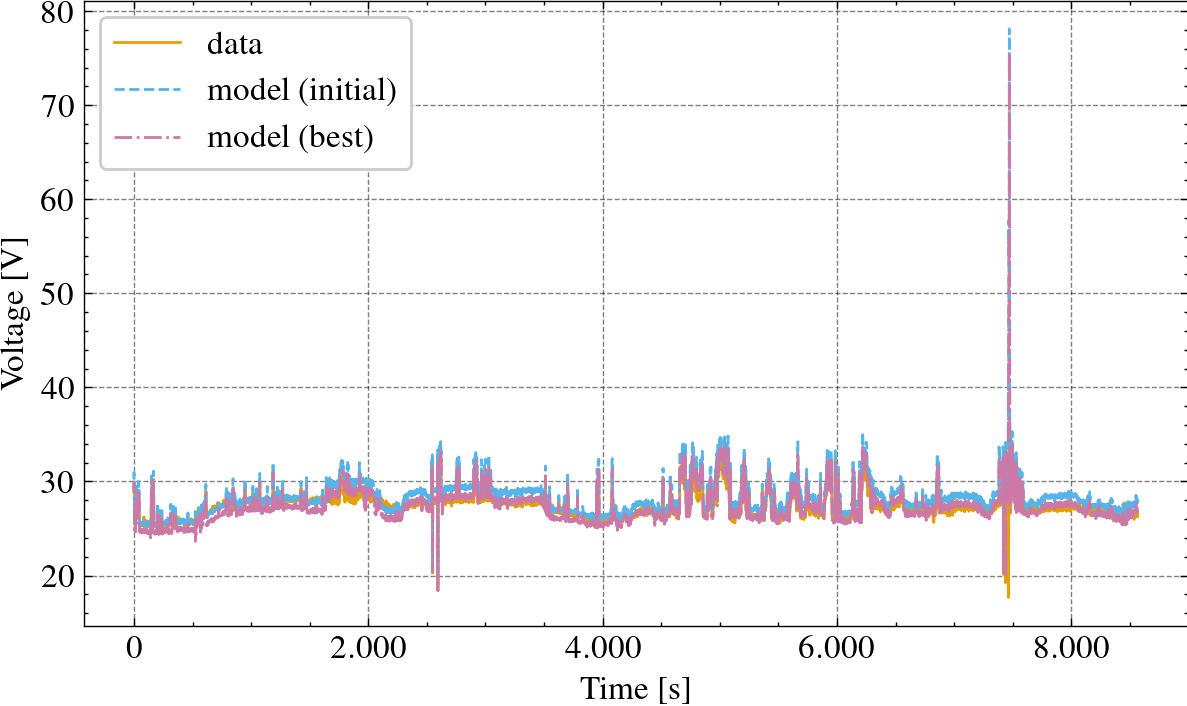

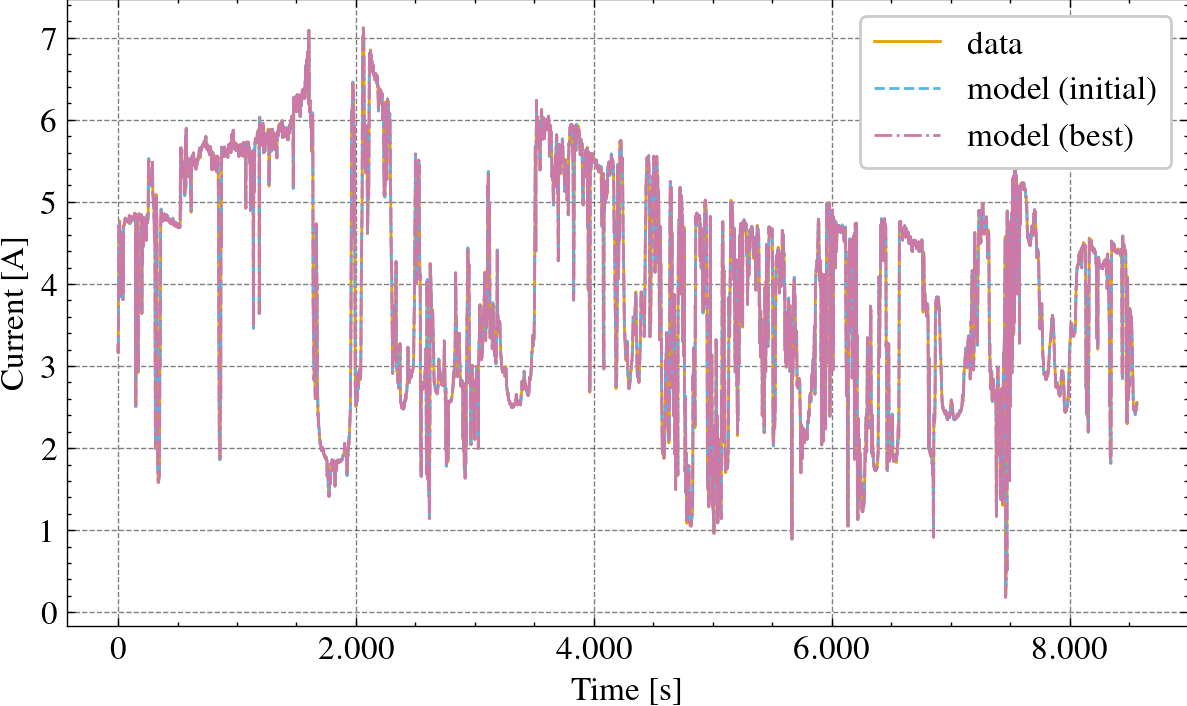

In [50]:
class MPPT_Power:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        eff = params['mppt_eta']

        # Get the inputs
        D = u[0]
        Ii = u[1]
        Vo = u[2]

        # Saturate D
        D = np.clip(D, 0, 0.9)

        max_gain = 20
        M = np.clip(D / (1 - D), 0, max_gain)

        Io = Ii / M if M > 0 else 0

        Vi = Vo / (M * eff) if M > 0 else 0

        return (Vi, Io)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name='mppt_p_outwer',
            states=None,
            inputs=('D', 'Ii', 'Vo'),
            outputs=('Vi', 'Io'),
            params=params,
        )

def func(T, U, **params):
    return ct.input_output_response(MPPT_Power.build(params), T=T, U=U, solve_ivp_method="Radau").outputs[0]#.T

model = lmfit.Model(func=func, independent_vars=["T", "U"])

# Parameters
params = lmfit.Parameters()
params.add('mppt_eta', value=0.9, min=0.5, max=1.0, vary=True)

# Downsample the data to optimize
df_lf = df.copy()#.resample('5s').mean()

# Time array
T = (df_lf.index[1] - df_lf.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df_lf.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df_lf[['mppt1_d', 'mppt1_ii', 'batt_v']].to_numpy().T
data = df_lf['mppt1_vi'].to_numpy()

# Optimize
result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    method='least_squares',
)

# Evaluate
ydata_init = input_output_response_to_pandas(ct.input_output_response(MPPT_Power.build(result.init_values), T=T, U=U, solve_ivp_method="Radau"))
ydata = input_output_response_to_pandas(ct.input_output_response(MPPT_Power.build(result.best_values), T=T, U=U, solve_ivp_method="Radau"))

residuals = df_lf[['mppt1_vi', 'mppt1_io']].to_numpy() - ydata[['Vi', 'Io']].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure()
plt.plot(T, df_lf['mppt1_vi'], label='data')
plt.plot(T, ydata_init['Vi'], label='model (initial)')
plt.plot(T, ydata['Vi'], label='model (best)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(T, df_lf['mppt1_io'], label='data')
plt.plot(T, ydata_init['Io'], label='model (initial)')
plt.plot(T, ydata['Io'], label='model (best)')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.legend()
plt.tight_layout()
plt.show()

display(result)

mppt_p_outwer_params = result.best_values

<NonlinearIOSystem:mppt_controller:['G', 'Ta', 'vw', 'Vi', 'Ii', 'Vo', 'Io']->['D']>

Index(['time', 'G', 'Ta', 'vw', 'Vi', 'Ii', 'Vo', 'Io', 'D'], dtype='object')
rmse: 0.018818030075830328
mae: 0.01611229135686876


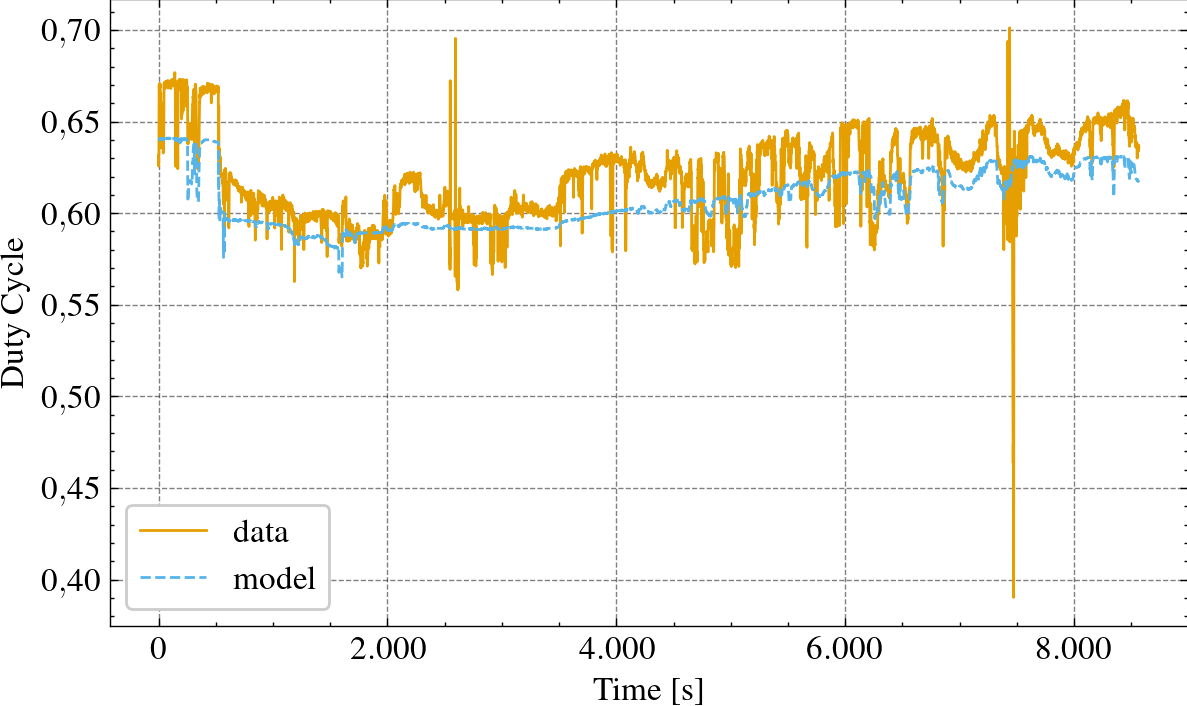

In [51]:
class MPPT_controller_MPP:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]
        eff = params['mppt_eta']

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]
        Vi = u[3]  # Solar panel voltage [V]
        # Ii = u[4]  # Solar panel current [A]
        Vo = u[5]  # MPPT output voltage (Battery voltage) [V]
        # Io = u[5]  # MPPT output current (to the battery node) [A]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        Tc = pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        i_mp, v_mp, _p_mp = pvlib.pvsystem.max_power_point(photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='brentq').values()

        Vi = v_mp
        M = (Vo / (Vi * eff)) if Vi > 0 else 0

        D = M / (1 + M)
        return np.clip(D, a_min=0, a_max=1)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="mppt_controller",
            states=None,
            inputs=('G', 'Ta', 'vw', 'Vi', 'Ii', 'Vo', 'Io'),
            outputs=('D',),
            params=params,
        )


mppt_controller_params = {}
mppt_controller_params |= pv_diode_params
mppt_controller_params |= pv_th_params
mppt_controller_params |= mppt_p_outwer_params

mppt_controller = MPPT_controller_MPP.build(mppt_controller_params)
display(mppt_controller)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'mppt1_vi', 'mppt1_ii', 'batt_v', 'mppt1_io']].to_numpy().T

res = ct.input_output_response(mppt_controller, T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)
print(ydata.columns)

residuals = df['mppt1_d'].to_numpy() - ydata['D'].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure()
plt.plot(T, df['mppt1_d'], label='data')
plt.plot(T, ydata['D'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Duty Cycle')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
# MPPT WITH P&O ALGORITHM -- THIS IS NOT WORKING!

# class MPPT_controller_PO:
#     @classmethod
#     def _updates(cls, t, x, u, params: dict):
#         k = x[3]

#         # Clock divider
#         if k < 10:
#             k += 1
#             return [x[0], x[1], x[2], k]
#         k = 0

#         # Inputs
#         Vi = u[0]  # Solar panel voltage [V]
#         Ii = u[1]  # Solar panel current [A]

#         # States
#         D = x[0]
#         dD = x[1]
#         Pi_old = x[2]

#         # Constants
#         D_step = 0.01
#         D_min = 0.2
#         D_max = 0.8
#         Pi_deadzone = 0

#         # So it doesn't require initial value
#         if dD == 0:
#             dD = 1
#             D = 0.8

#         # P&O
#         Pi = Vi * Ii
#         if (Pi < (Pi_old - Pi_deadzone)) or (D == D_max) or (D == D_min):
#             dD *= -1
#         D += dD * D_step

#         D = np.clip(D, a_min=D_min, a_max=D_max)

#         return [D, dD, Pi, k]

#     @classmethod
#     def _outputs(cls, t, x, u, params: dict):
#         return x[0]

#     @classmethod
#     def build(cls, params: dict = {}):
#         return ct.NonlinearIOSystem(
#             cls._updates,
#             cls._outputs,
#             dt=1,
#             name="mppt_controller",
#             states=('M', 'dM', 'Pi', 'k'),
#             inputs=('Vi', 'Ii'),
#             outputs=('D',),
#             params=params,
#         )

# mppt_controller_params = {}
# mppt_controller_params |= pv_diode_params
# mppt_controller_params |= pv_th_params
# mppt_controller_params |= mppt_p_outwer_params

# mppt_controller = MPPT_controller_PO.build(mppt_controller_params)
# display(mppt_controller)

# # Time array
# T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
# lenT = len(df.index)
# T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# # Data
# U = df[['mppt1_vi', 'mppt1_ii']].to_numpy().T

# res = ct.input_output_response(mppt_controller, T=T, U=U, solve_ivp_method="Radau")
# ydata = input_output_response_to_pandas(res)
# print(ydata.columns)

# pi = ydata['Vi'] * ydata['Ii']
# pi /= pi.max()

# plt.figure()
# plt.plot(T, df['mppt1_d'], label='data')
# plt.plot(T, ydata['D'], label='model')
# # plt.plot(T, pi, label='Pi')
# plt.xlabel('Time [s]')
# plt.ylabel('Duty Cycle')
# plt.legend()
# plt.show()


<InterconnectedSystem:mppt:['G', 'Ta', 'vw', 'Vo', 'Ii']->['Vi', 'Io']>

Index(['time', 'G', 'Ta', 'vw', 'Vo', 'Ii', 'Vi', 'Io'], dtype='object')
rmse: 1.349340223972217
mae: 0.9841368591341616


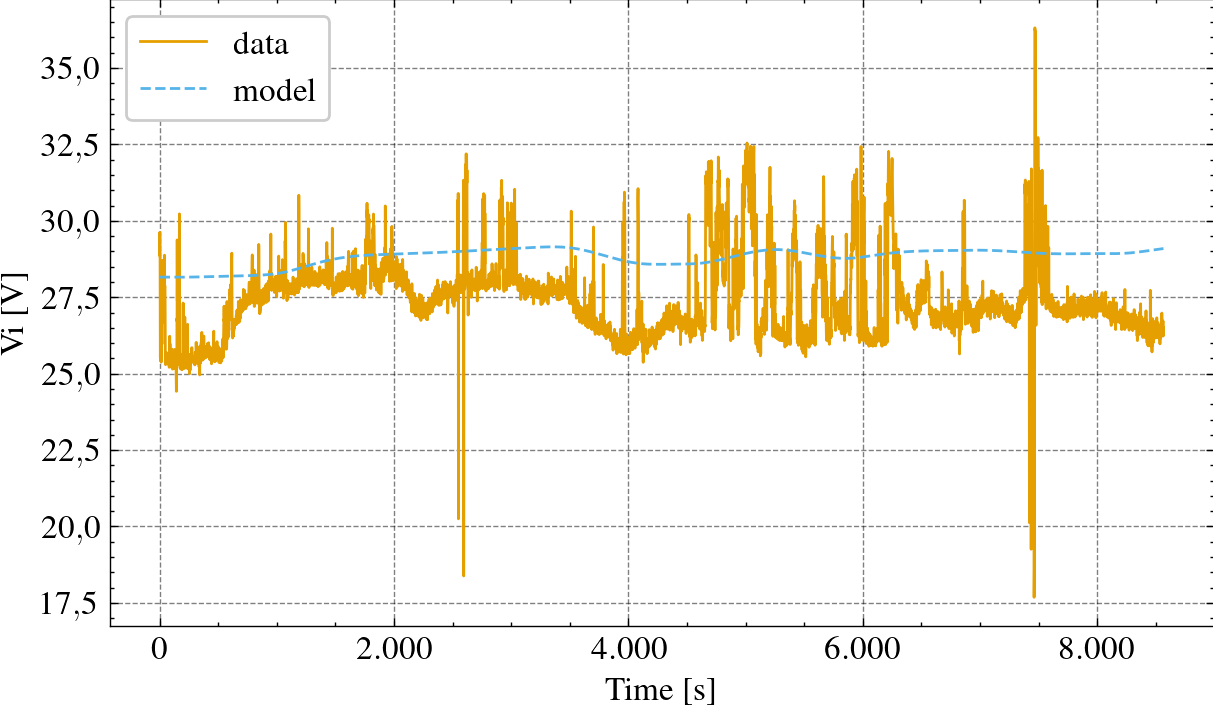

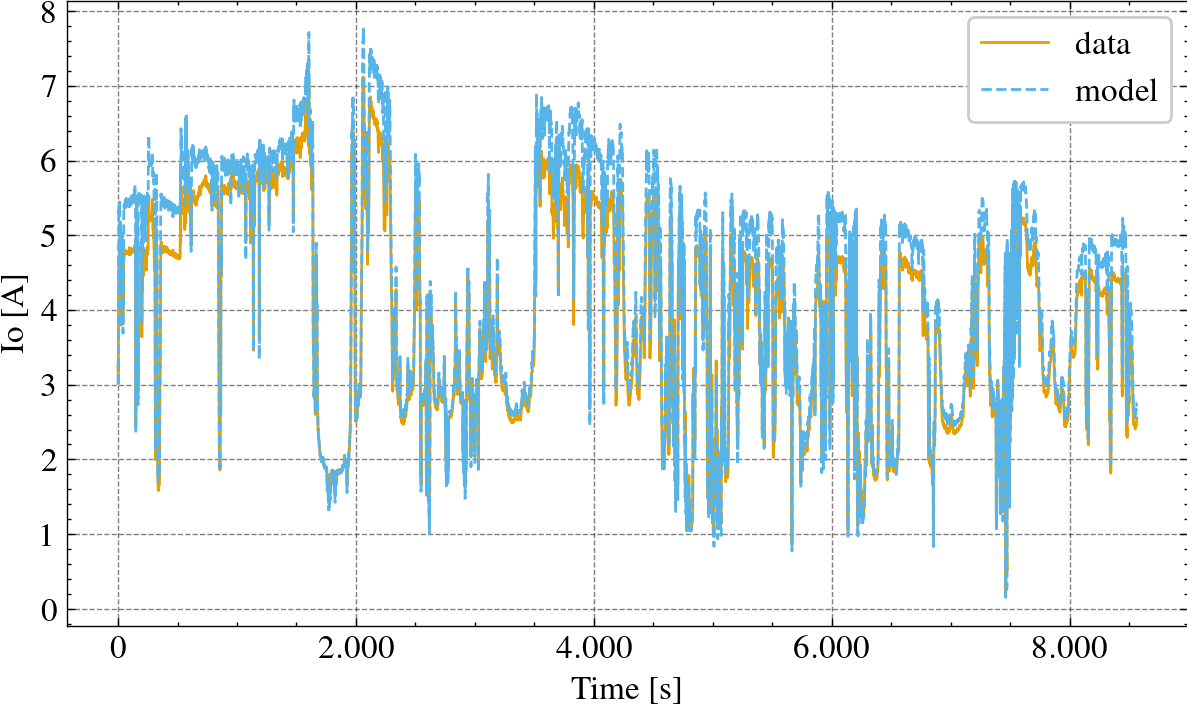

In [53]:
class MPPT:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.interconnect(
            (
                MPPT_Power.build(params),
                MPPT_controller_MPP.build(params),
            ),
            name='mppt',
            connections=(
                ('mppt_p_outwer.D', 'mppt_controller.D'),
                ('mppt_controller.Vi', 'mppt_p_outwer.Vi'),
                ('mppt_controller.Io', 'mppt_p_outwer.Io'),
            ),
            inplist=('mppt_controller.G', 'mppt_controller.Ta', 'mppt_controller.vw', ['mppt_controller.Vo', 'mppt_p_outwer.Vo'], ['mppt_controller.Ii', 'mppt_p_outwer.Ii']),
            inputs=('G', 'Ta', 'vw', 'Vo', 'Ii'),
            outlist=('mppt_p_outwer.Vi', 'mppt_p_outwer.Io'),
            outputs=('Vi', 'Io'),
        )

mppt_params = {}
mppt_params |= pv_diode_params
mppt_params |= pv_th_params
mppt_params |= mppt_p_outwer_params

mppt = MPPT.build(mppt_params)
display(mppt)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'batt_v', 'mppt1_ii']].to_numpy().T

res = ct.input_output_response(mppt, T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)
print(ydata.columns)

residuals = df[['mppt1_vi', 'mppt1_io']].to_numpy() - ydata[['Vi', 'Io']].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure()
plt.plot(T, df['mppt1_vi'], label='data')
plt.plot(T, ydata['Vi'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Vi [V]')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(T, df['mppt1_io'], label='data')
plt.plot(T, ydata['Io'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Io [A]')
plt.legend()
plt.tight_layout()
plt.show()

## Generation

In [54]:
generation = ct.interconnect(
    (
        ct.rss(name='solar_panel', inputs=('G', 'Ta', 'vw', 'V'), outputs=('I',)),
        ct.rss(name='mppt', inputs=('G', 'Ta', 'vw', 'Vo', 'Ii'), outputs=('Vi', 'Io')),
    ),
    name='generation',
    connections=(
        ('solar_panel.V', 'mppt.Vi'),
        ('mppt.Ii', 'solar_panel.I'),
    ),
    inplist=(['solar_panel.G', 'mppt.G'], ['solar_panel.Ta', 'mppt.Ta'], ['solar_panel.vw', 'mppt.vw'], 'mppt.Vo'),
    inputs=('G', 'Ta', 'wv', 'Vo'),
    outlist=('mppt.Io',),
    outputs=('Io',),
)
generation

<LinearICSystem:generation:['G', 'Ta', 'wv', 'Vo']->['Io']>

<InterconnectedSystem:generation:['G', 'Ta', 'wv', 'Vo']->['Io']>

Index(['time', 'G', 'Ta', 'wv', 'Vo', 'Io'], dtype='object')
rmse: 1.2505797901324138
mae: 1.0046781209633042


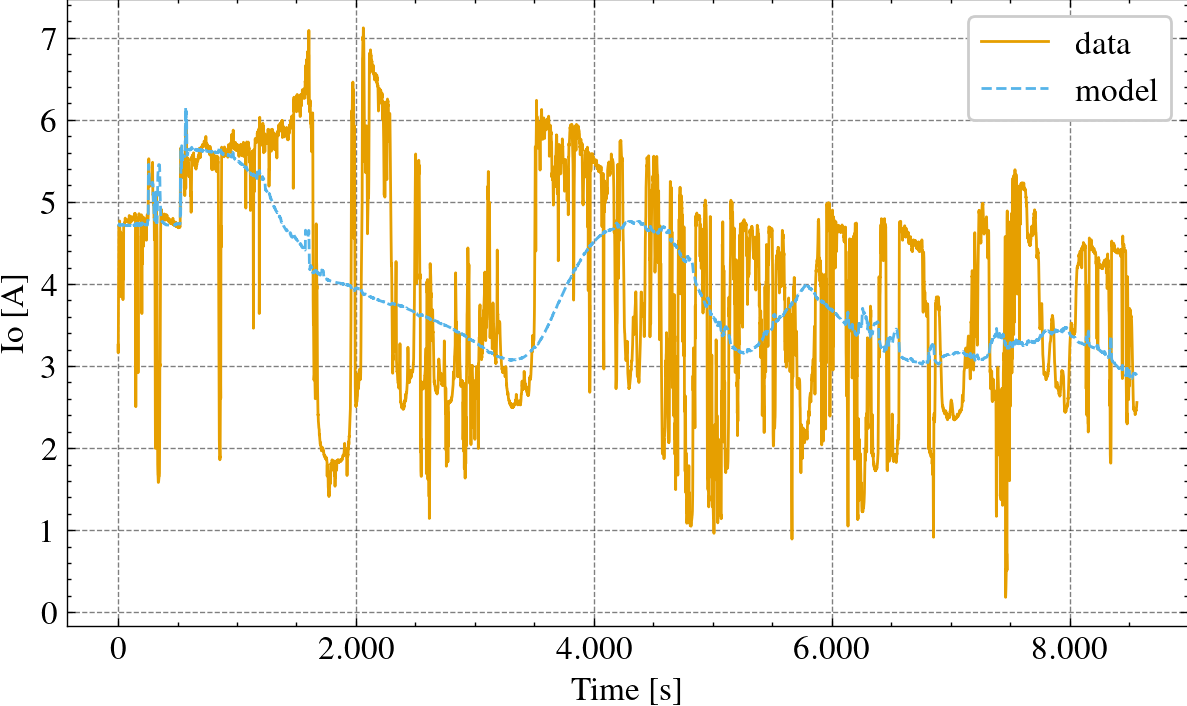

In [55]:
class Generation:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.interconnect(
            (
                SolarPanel.build(params),
                MPPT.build(params),
            ),
            name='generation',
            connections=(
                ('solar_panel.V', 'mppt.Vi'),
                ('mppt.Ii', 'solar_panel.I'),
            ),
            inplist=(['solar_panel.G', 'mppt.G'], ['solar_panel.Ta', 'mppt.Ta'], ['solar_panel.vw', 'mppt.vw'], 'mppt.Vo'),
            inputs=('G', 'Ta', 'wv', 'Vo'),
            outlist=('mppt.Io',),
            outputs=('Io',),
        )

generation_params = {}
generation_params |= pv_params
generation_params |= mppt_params

generation = Generation.build(generation_params)
display(generation)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'batt_v']].to_numpy().T

res = ct.input_output_response(generation, T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)
print(ydata.columns)

residuals = df['mppt1_io'].to_numpy() - ydata['Io'].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure(figsize=figsize('abntex2'))
plt.plot(T, df['mppt1_io'], label='data')
plt.plot(T, ydata['Io'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Io [A]')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
generation_params

{'pv_Iph_STC': 8.738959068154207,
 'pv_I0_STC': 2.1982994421060667e-10,
 'pv_Rs_STC': 0.1853708789540368,
 'pv_Rp_STC': 833.8269824839556,
 'pv_a_STC': 1.529627874530232,
 'pv_Asc': 0.0053879999999999996,
 'pv_Eg_STC': 1.121,
 'pv_dEgdT_STC': -0.0002677,
 'pv_Tc_STC': 25,
 'pvs_g_STC': 1000,
 'pv_th_alpha': 0.88,
 'pv_th_u0': 25.0,
 'pv_th_u1': 6.84,
 'mppt_eta': 0.9303414194668972}

# Simplified Generation Model

In [64]:
class SimpleGeneration:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]
        eff = params['mppt_eta']

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        Ta = u[1]  # Ambient dry bulb temperature [ºC]
        vw = u[2]  # Wind speed at a height of 10 meters [m/s]
        Vo = u[3]  # MPPT output voltage (Battery voltage) [V]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        Tc = pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=vw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Ii, Vi, Pi = pvlib.pvsystem.max_power_point(photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='brentq').values()

        Po = Pi * eff
        Io = Po / Vo if Vo > 0 else 0

        # M = (Vo / (Vi * eff)) if Vi > 0 else 0
        # D = np.clip( M / (1 + M), a_min=0, a_max=1)

        return Io

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="generation",
            states=None,
            inputs=('G', 'Ta', 'vw', 'Vo'),
            outputs=('Io',),
            params=params,
        )

SimpleGeneration.build(generation_params)


<NonlinearIOSystem:generation:['G', 'Ta', 'vw', 'Vo']->['Io']>

Index(['time', 'G', 'Ta', 'vw', 'Vo', 'Io'], dtype='object')
rmse: 1.2505797901324138
mae: 1.0046781209633042


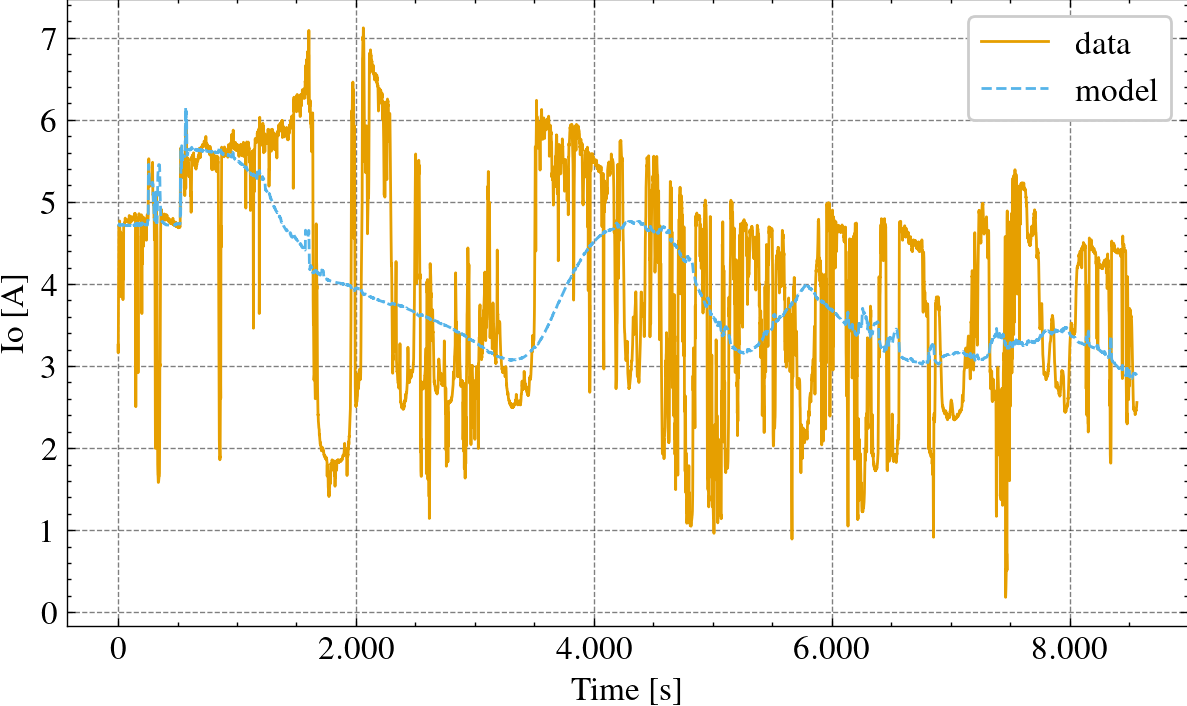

In [65]:
# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'batt_v']].to_numpy().T

res = ct.input_output_response(SimpleGeneration.build(generation_params), T=T, U=U, solve_ivp_method="Radau")
ydata = input_output_response_to_pandas(res)
print(ydata.columns)

residuals = df['mppt1_io'].to_numpy() - ydata['Io'].to_numpy()
residuals = residuals[~np.isnan(residuals)]
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))
print(f'rmse: {rmse}')
print(f'mae: {mae}')

plt.figure(figsize=figsize('abntex2'))
plt.plot(T, df['mppt1_io'], label='data')
plt.plot(T, ydata['Io'], label='model')
plt.xlabel('Time [s]')
plt.ylabel('Io [A]')
plt.legend()
plt.tight_layout()
plt.show()